<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/%F0%9F%9B%A0Time_Series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to get myself familiar with working with the time series data. In here, we're going to build a series of models in an attempt to predict the price of a **Bitcoin**

> 🔑 Note: ⚠️ This is not financial advice, as you'll see time series forecasting for stock market prices is actually quite terrible.

## Things we're going to cover 

- Get time series data (the historical price of Bitcoin)
  - Load in time series data using pandas/Python's CSV module
- Format data for a time series problem 
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data. 
- Evaluating a time series forecasting model. 
- Setting up a series of deeplearning modelling experiments. 
  - Dense (fully connected) networks 
  - Sequence models (LSTM and Conv1D) 
  - Ensembling (combining multiple models together) 
  - Multivariate models 
  - Replicating the N-BEATS algorithm (from the paper itself) using the TensorFlow Subclassing layers. 
- Creating a modelling checkpoint to save the best perfomring mdoel during training. 
- Making predictions (forecasts) with a time series model. 
- Creating prediction interval for time series model forecasts. 
- Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity). 
- Demonstrating why forecasting in an open system is BullShit (the turkey problem). 


### A bit about forecasting & Time Series 

Some things are easier to forecast than others. The time of the sunrise tomorrow morning can be forecast precisely. On the other hand, tomorrow’s lotto numbers cannot be forecast with any accuracy. The predictability of an event or a quantity depends on several factors including:

- how well we understand the factors that contribute to it;
- how much data is available;
- how similar the future is to the past;
- whether the forecasts can affect the thing we are trying to forecast.


### In a nutshell 

- Downloading and formatting time series data (the historical price of Bitcoin). 
- Writing **a preprocessing function** to preparrre our time series data 
- Setting up **multiple time series modelling experiments**. 
- Building a **multivariate model** to take in multivariate time series data. 
- Replicating the N-Beats algorithm using TensorFlow. 
- Making forecasts with **prediction intervals**. 
- Demonstrating **why time series forecasting can be bullshit** with the turkey problem. 


## Downloading the getting to know the data 
We're going to be using historical price of data of Bitcoin to try and predict the future price of Bitcoin. 

In [2]:
# Downloading the dat 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-27 11:52:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-08-27 11:52:04 (9.86 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



#### Importing the time series data using Pandas 

Let's use pandas and visualize the data in a pretty table. 

And because our data has a data component, we'll tell pandas to parse the dates using the `parse_dates` parameter pasing it the name of the data column. 

In [3]:
import pandas as pd 

# parse dates and set data column to index 
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv' , 
                 parse_dates = ['Date'] , 
                 index_col = ['Date']) # setting the Date col to index column 

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
# Info about our data 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have? 
len(df)

2787

We've collected the historical price of the Bitcoin for the past 8 years but there's only **2787 samples**. 

Typically deeplearning models usually like lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions). 

A smaller number of samples is something you'll often run into with time series data problems. 

> **Note**: The seasonality of the time series dataset is referred as the number of samples per yes. So for our Bitcoint data, it has a seasonlity of daily or value of 365 because we collect one sample per dat meaning we'll get 365 samples per year. 

There are various patterns in the time series data.  

- **Trend** —> time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal** —> time series affected by a seasonal factors such as time of year (e.g. increased sales towards end of year) or day of week.
- **Cyclic** —> time series shows rise and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

**Difference between season and cyclic** 

Seasonal is fixed where the things happen at a particular year or week etc.. But with cyclic its not the case, as there is no any time frame to determine when the events could take place

- **Univariate** --> Only one variable (using the price of Bitcoin to predict the price of Bitcoin). 
- **Multivariate** --> For Multivariate, there are more than one variable (using the price of Bitcoin as well as the block reward size  to predict the price of Bitcoin) which is using multiple features for prediction. 

In [6]:
# Only getting the closing price for each dat 
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns = {'Closing Price (USD)': 'Price'})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


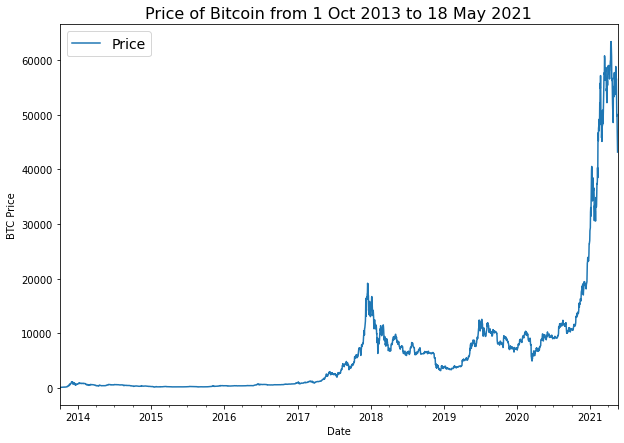

In [7]:
# Lets plot the prices vs data 
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10 , 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021' , fontsize =16)
plt.legend(fontsize = 14);

#### Importing time series data with Python CSV module 

Its not always necessary to use pandas. We can use Python's built in csv module, and we also gotta use Python's `datetime`. 

Resources --> https://realpython.com/python-csv/

In [8]:
# Importing annd formatting historical Bitcoin data with Python 
import csv 
from datetime import datetime 

timesteps = []
btc_price = [] 
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv' , 'r') as f:
  csv_reader = csv.reader(f , delimiter = ',') # read the csv file using python csv lib 
  next(csv_reader) # iterate the rows and skip the first line (which is our header)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1] , '%Y-%m-%d')) # indexing into the dates and storing it in a list with datetime format
    btc_price.append(float(line[2])) # get the closing price as float 
                     

# View first 10 of each 
timesteps[:10] , btc_price[:10]


([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0, 0.5, 'BTC Price')

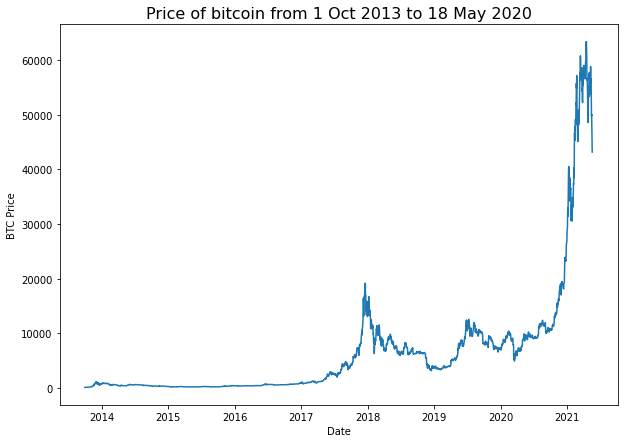

In [9]:
# Plot the aboce csv 
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize = (10 , 7))
plt.plot(timesteps , btc_price)
plt.title('Price of bitcoin from 1 Oct 2013 to 18 May 2020' , fontsize = 16)
plt.xlabel('Date')
plt.ylabel('BTC Price')

### Formatting Data Part 1 : Creating train and tests for our time series data 


Usually we will be creating a train and test split using a function like Scikit-learn's `train_test_split()` but its not the case for the time series data. 

Before splitting we should know what kind of data we're dealing with and we will either have a **univariate data** or **multivariate data**. 
- **Univariate** time series data deals with one variable, for example using the price of Bitcoint to predict the price of Bitcoin.
- **Multivariate** time series data deals with more than one variable, for example predicting electricity demand using the day of week, time of year and number of houses in a region. 

> We're dealing with a univariate time series problem, so we have to make a split on one variable. 



#### Create train and test set for time series (the wrong way) 




In [10]:
# Get bitcoin data array 
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10] , prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test set for time series 
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(timesteps , #dates 
                                                       prices , #prices , 
                                                       test_size = 0.2 , 
                                                       random_state = 42)

# Checking the shapes 
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((2229,), (558,), (2229,), (558,))

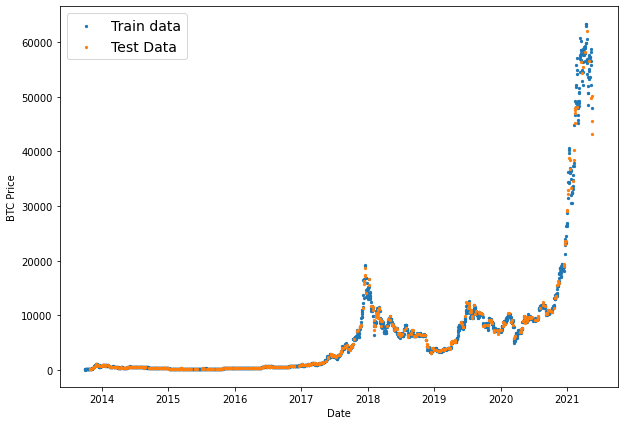

In [12]:
# Lets visualize the splits we made 
plt.figure(figsize = (10 , 7))
plt.scatter(X_train , y_train , s = 5 , label ='Train data')
plt.scatter(X_test , y_test , s = 5 , label = 'Test Data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize = 14)
plt.show()

The above split isn't the ideal way for a time series data because ur test data is scattered all throughout the training data. 

This kind of random splits will be fine for datasets without a time component, but for time series, we have to got take the time factor into account. 

In other words it is data leakage. 

We need to split our Historical Bitcoin data to have a **dataset that reflects the past (train set) and a dataset that reflects the future (test data or pseudo future)**.

#### Create train and test sets for a time series (the right way) 





In [13]:
split_size = int(0.8 * len(prices)) # 80% train , 20% test (can change this values)

# Create train data splits (everything before the split)
X_train , y_train = timesteps[:split_size] , prices[:split_size]

# Create test data splits (everything after the split)
X_test , y_test = timesteps[split_size:] , prices[split_size:]

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(2229, 558, 2229, 558)

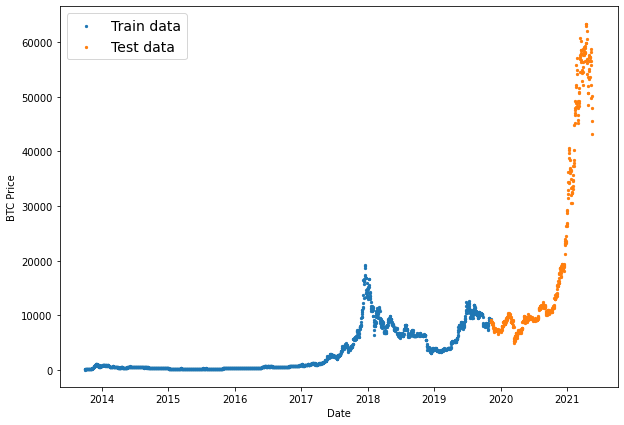

In [14]:
# Visualizing the above splits (the right one)
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

Beautiful! Here we're going to be using the training set (past) to train a model to try and predict values on the test set (future). 

Our test set is an artifical future, at the end we can try our model on the whole data as a training set. 

> **🔑 Note** The amount of data you reserve for your test set is not set in stone. You could have 80/20 , 90/10 , 95/5 splits or in some cases, you might not even have a enough data to split into train and test sets. The point is to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 Resource: Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data, I'd recommend reading it.

##### Creating a plot function to visualize our time series data 



In [15]:
def plot_time_series(timesteps , values ,format = '.' , start = 0 , end = None , label = None):
  '''
  Plots a timesteps (a series of point in time) against values (a series of values across timesteps)

  Parameters 
  ----------

  timesteps : array of timesteps (date)
  values : array of values across time 
  format : style of plot , default '.'
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  '''

  # Plot the serie 
  plt.plot(timesteps[start:end] , values[start:end] , format , label = label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)

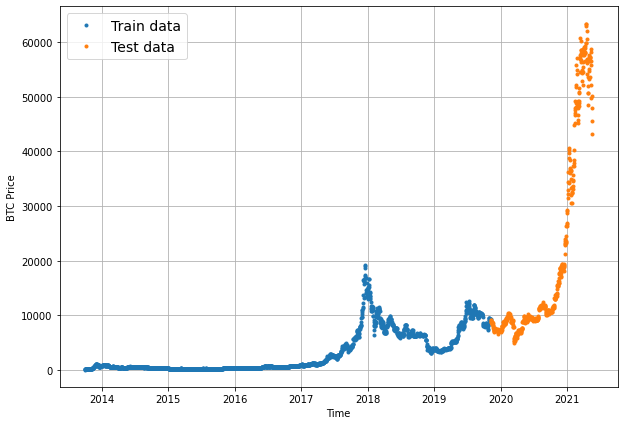

In [16]:
# Trying out our plotting function 
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_train , values = y_train , label ='Train data')
plot_time_series(timesteps = X_test , values = y_test , label = 'Test data')

Later try to experiment with this: Sklearns [timeseries split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

## **Modelling Experiments**

We've got some bitcoin historical data, to model it, lets run a series of modelling experiments and see which model performs the best. 

Terms to be familiar with, 
* **Horizon** --> Number of timesteps into the future we're going to predict. 
* **Window Size** --> Number of timesteps we're going to predict **horizon**

Modelling experiments we're running: 
- 0	Naïve model (baseline)	
- 1	Dense model	(horizon = 1 , window = 7)	
- 2	Same as model 1 (horizon = 1 , window = 30)
- 3	Same as model 1 (horizon = 7	window =30)	
- 4	Conv1D	(horizon =1 , window =7)	
- 5	LSTM	(horizon =1 , window =7)
- 6	Same as 1 (but with multivariate data)	(horizon =1	, window = 7)	Block reward size
- 7	N-BEATs Algorithm	(horizon =1 , window	=7)	
- 8	Ensemble (multiple models optimized on different loss functions)	(horizon = 1	, window =7)	
- 9	Future prediction model (model to predict future values)	(horizon = 1 , window=	7)	
- 10	Same as 1 (but with turkey 🦃 data introduced)	(horizon = 1 , window= 7)

### Model 0 : Naive Forecast (baseline) 

One of the most common baeline models for time series forecasting, the naive model (also called [naive forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)) requires no training at all. 

Thats because all the naive model does is use the previous timestep values (horizon) to predict the next timestep values (window). 

$$\hat{y}_{t} = y_{t-1}$$

> The above formula implies, the prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep). 

In an open system (stock market or crypto market) beating the naive forecast with any kind of model is quite hard. 

Its naive because it blindly predicts the previous timestep the next timestep. 



In [17]:
# Create a naive forecast 
naive_forecast = y_test[:-1]  # except every value excluding the last one

# Looking at first and last 10 values 
naive_forecast[:10] , naive_forecast[:10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]))

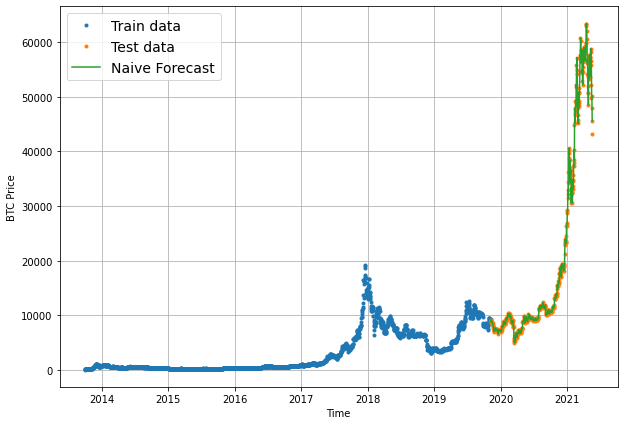

In [18]:
# Plot the naive forecast 
plt.figure(figsize = (10 , 7))
plot_time_series(timesteps= X_train , values = y_train , label = 'Train data')
plot_time_series(timesteps= X_test , values = y_test , label = 'Test data')
plot_time_series(timesteps = X_test[1:] , values=naive_forecast , format = '-' , label= 'Naive Forecast')

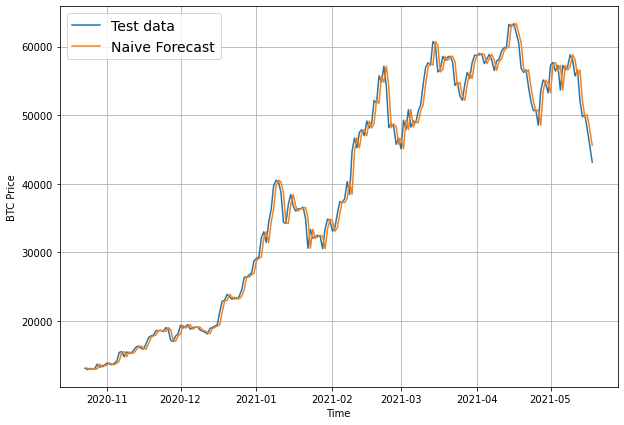

In [19]:
# Looking into the test and the naive forecast (this is for closer observation to determine the performance)
plt.figure(figsize= (10 , 7))
plot_time_series(X_test , y_test , start= 350 , format = '-' , label = 'Test data')
plot_time_series(X_test[1:] , naive_forecast , start = 350 , format = '-',label='Naive Forecast')

If we can clearly observe the above graph, we can see that there is a slight lag (or gap) between the test data and naive forecast. 

This indicates how close were the prediction of naive forecast were compared to the test data. 

**Naive forecast is quite hard to beat.**

> To know more about this check [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html). Also search and find out why naive forecast is hard to beat, keep an eye out for the term AutoRegressive. 

### **Evaluating a time series model**

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin). And its a Regression problem. 

With this known, we can use regression evaluation metrics to evaluate our time series forecasts. 

The main thing we will be evaluating is: 
> **how do our models predictions (y_pred) compares against the actual values (y_true or ground truth values)?**

For all of the followiing metrics, **lower is better** (for example an MAE of 0 is better than an MAE 50). 

#### **Scale Dependent errors**

There are the metrics which can be used to compare time series values and forecasts that are on the same scale. 

For example, Bitcoin historical prices in USD veresus Bitcoin forecast values in USD.

* **MAE (mean absolute error)** `tf.keras.metrics.mean_absolute_error()` : Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. 
* **RMSE (root mean squared error) `tf.keras.metrics.mean_square_error()`**: Forecasts which minimise the RMSE lead to forecasts of the mean.

#### **Percentage Errors** 

Percentage erros do not have any units, this means they can be used to compare forecasts across different datasets. 

* **MAPE (mean absolute percentage error) `tf.keras.metrics.mean_absolute_percentage_error()`**: Most commonly used percentage error. May explode (not work) if y=0.
* **sMAPE (symmetric mean absolute percentage error) `Custom Implementation`**: Recommended not to be used by Forecasting: Principles and Practice, though it is used in forecasting competitions.

#### **Scaled Errors**
Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series. 

- **MASE (mean absolute scaled error) `See sktime's mase_loss()`**: MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE.

> **🤔 Question**: There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Lets write a function to help us calculate evaluation metrics on their forecasts. Also we need to implement the MASE using TensorFlow. 

In [20]:
# Importing tensorflow 
import tensorflow as tf 

In [21]:
# MASE implemented courtesy of sktime -
# https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16

def mean_absolute_scaled_error(y_true , y_pred):
  '''
  Implement MASE (assuming no seasonality of data)
  '''
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day 

  return mae / mae_naive_no_season

In [22]:
mean_absolute_scaled_error(y_true = y_test[1:] , y_pred = naive_forecast).numpy()

0.9995699939182624

You'll notice the version of MASE above doesn't take in the training values like sktime's mae_loss(). In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

In [23]:
# Putting each of our different evaluation metrics together into a function 
def evaluate_preds(y_true , y_pred):

  '''
  Inputs
  ------
   --> y_true (truth labels)
   --> y_pred (predicted labels)

  Returns
  -------
    --> MAE 
    --> MSE 
    --> RMSE
    --> MAPE/sMAPE
    --> MASE
  '''

  # Make sure float32 for the metric calculations
  y_true = tf.cast(y_true , tf.float32)
  y_pred = tf.cast(y_pred , tf.float32)

  # Calculating the evalution metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true , y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true , y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true , y_pred)
  mase = mean_absolute_scaled_error(y_true , y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
# Testing the above function 
naive_results = evaluate_preds(y_true= y_test[1:] , 
                               y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Great now we've a got some baselines to beat. 

Taking a look at the naives forecast MAE, it seems on average each forecast is **~$567** different than the actual Bitcoint price. 

How does this compare to the average price of Bitcoin in the test dataset? 


In [25]:
# Find average prie of Bitcoin the test dataset 
tf.reduce_mean(y_test).numpy()

20056.632963737226

Looking at these two values is starting to give us an idea of how our model is performing: 
- The average price of Bitcoin in the test dataset is: `$20,056` (note: average may not be the best measure here, since the highes price is over 3x this value and the lowest price is over 4x lower). 
- Each prediction in naive forecast is on average off by: $567 

But for the lower values $567 might will be around 10% and thats not a good estimate. So will try to build models and see if we can beat our baseline. 

#### **Other kinds of time series forecasting models which can be used for baselines and actual forecasts** 

There are many other kinds of models we may want to look into for building baselines/performing forecasts. 

Some of them may even beat our best performing models in this notebooks. 

- [Moving average](https://www.notion.so/Moving-average-7c2cf9844452466f94b2f9e854b60f40)

- [ARIMA (Autoregression Integrated Moving Average)](https://www.notion.so/ARIMA-Autoregression-Integrated-Moving-Average-75d9bdc1c2ff47b3afe78ba6e21bfabb)

- [sktime (Scikit-Learn for time series)](https://www.notion.so/sktime-Scikit-Learn-for-time-series-fc5d1a5d94924dceb9ed4bd2a10480a9)

- [TensorFlow Decision Forests (random forest, gradient boosting trees)](https://www.notion.so/TensorFlow-Decision-Forests-random-forest-gradient-boosting-trees-dfb792e083f947909aed6941cd6c2e8d)

- [Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)](https://www.notion.so/Facebook-Kats-purpose-built-forecasting-and-time-series-analysis-library-by-Facebook-cc48a26a54c34b3e9dac5c05da5e2795)

- [LinkedIn Greykite (flexible, intuitive and fast forecasts)](https://www.notion.so/LinkedIn-Greykite-flexible-intuitive-and-fast-forecasts-72c366489bb74e5e886c9190b010c02e)


### **Format Data Part 2: Windowing dataset**

Before we had the price and the timesteps as our dataset, but for the next series of modelling experiments we have to format our data into windows. 

Windowing is a method to turn a time series dataset into **supervised learning problem.**

**In other words, we want to use windows of the past to predict the future**

For example for a univariate time series, windowing for one week (window=7) to predict the next single value (horizon=1) might look like:

Window for one week (univariate time series)
```
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```
Or for the price of Bitcoin, it'd look like:

Window for one week with the target of predicting the next day (Bitcoin prices)
```
[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [26]:
# What we want to do with our Bitcoin data 
print(f'We want to use: {btc_price[:7]} to predict this --> {btc_price[7]}')

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this --> 123.033


In [27]:
# Lets setup global variables for window and horizon size (Hyperparameters)
HORIZON = 1 # predict 1 step at a time 
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the bitcoin 

In [28]:
# Writing a function to label windowed data 

def get_labelled_windows(x , horizon = HORIZON):
  '''
  Creates labels for windowed dataset 

  E.g. if horizon=1 (default)

  Input [1,2,3,4,5,6] --> Output: ([1 ,2 ,3 , 4 ,5] , [6])
  '''
  return x[: , :-horizon] , x[: , -horizon:]

In [29]:
# Testing out our window labelling function 
test_window , test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+ 1 , axis = 0))
print(f'Window: {tf.squeeze(test_window).numpy()} ---> Label: {tf.squeeze(test_label).numpy()}')

Window: [1 2 3 4 5 6 7] ---> Label: 8


We've got a way to label our windowed data. 

However, this only works on a small scale. 

We need a way to do the above across our entire time series data. 

We could use Python's for loops, but that would be quite slow. To speed things up, we'll leverage [Numpy array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html)

Lets write a function which: 
1. Creates a window step of specific window size, for example: [[0 , 1, 2, 3, 4, 5, 6, 7]]
2. uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0 ,1 ,2 ,3 ,4 ,5 ,6, 7]],
[[1, 2, 3, 4, 5, 6, 7, 8]],
[[2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multiple window steps to index on a target series (e.g the historical price of Bitcoin). 
4. Uses the `get_labelled_windows()` function we created above to turn the windows steps into windows with a specified horizon. 

Resource --> https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [30]:
import numpy as np 

In [31]:
# Create function to view NumPy arrays as windows (My make_windows function was wrong)
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [32]:
# Testing the above function 
make_windows(prices , window_size= 7 , horizon = 1)

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [33]:
# Lets store the variables 
full_windows , full_labels = make_windows(prices , window_size= 7 , horizon = 1)

# Length of the window and label 
len(full_windows) , len(full_labels)

(2780, 2780)

In [34]:
full_windows.shape

(2780, 7)

In [35]:
# View the first 3 windows/labels
for i in range(3):
  print(f'Window: {full_windows[i]} --> Label {full_labels[i]}\n\n')

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> Label [123.033]


Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> Label [124.049]


Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> Label [125.96116]




In [36]:
# View the last 3 windows/labels
for i in range(3):
  print(f'Window: {full_windows[i-3]} --> Label {full_labels[i-3]}\n\n')

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] --> Label [47885.62525472]


Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] --> Label [45604.61575361]


Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] --> Label [43144.47129086]




#### **Create train and test sets with the windowed data** 

Since we have formatted our data now we have to split them into train and test splits. 


In [37]:
# Creating a function to make the splits 
def make_train_test_splits(windows , labels , test_split = 0.2):
  '''
  Splits matching pairs of windows and labels into train and test splits
  '''
  split_size = int(len(windows) * (1 - test_split))
  
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]

  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows , test_windows , train_labels , test_labels

In [38]:
# Using the above function to make splits of data 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)

# Checking the length 
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2224, 556, 2224, 556)

In [39]:
train_windows.shape , test_windows.shape , train_labels.shape , test_labels.shape

((2224, 7), (556, 7), (2224, 1), (556, 1))

In [40]:
print(f' Train Windows: {train_windows[:5]}\n\n') 
print(f' Train Labels: {train_labels[:5]}\n\n') 
print(f' Test Windows: {test_windows[:5]}\n\n') 
print(f' Test Labels: {test_labels[:5]}\n\n') 

 Train Windows: [[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]
 [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]]


 Train Labels: [[123.033  ]
 [124.049  ]
 [125.96116]
 [125.27966]
 [125.9275 ]]


 Test Windows: [[9290.89660239 9202.41545055 9369.62808116 9326.59962378 9335.75240233
  9226.48582088 8794.35864452]
 [9202.41545055 9369.62808116 9326.59962378 9335.75240233 9226.48582088
  8794.35864452 8798.04205463]
 [9369.62808116 9326.59962378 9335.75240233 9226.48582088 8794.35864452
  8798.04205463 9081.18687849]
 [9326.59962378 9335.75240233 9226.48582088 8794.35864452 8798.04205463
  9081.18687849 8711.53433917]
 [9335.75240233 9226.48582088 8794.35864452 8798.04205463 9081.18687849
  8711.53433917 8760.89271814]]




In [41]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

#### **Make a modelling checkpoint** 

With the time series data the models performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples. 

That means we should make a fair comparison, we want to compare each models best performance against each models best performance. 

For example, if model_1 performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.



In [42]:
# Writing a function 
import os 

# Creating a function to implement a ModelCheckpoint callback 
def create_model_checkpoint(model_name , save_path = 'model_experiment/'):
  return tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_path , model_name) , # filepath + model_name 
                                            verbose = 0 , # prints only limited info
                                            save_best_only = True # Save only the best model
                                            )

YAYAA!!! 

Finally its time to continue with our modelling experiments and there is no stopping!!! 

We've been through a fair bit of preprocessing and its important to prepare our data for a model and its one of the largest parts of a machine learning project. 

Lets jump into the Model 1, which is a Dense model. 

### **Model 1: Dense model (windows = 7 , horizon = 1)**

We're going to keep our `model_1` simple af, 
- A single dense layer with 128 hidden units and ReLu activation. 
- An output layer with linear activation which means no activation (hence its a continous value). 
- Adam Optimizier and MAE as loss function for compiliing the model. 
- Train the model for 100 epochs and use the above model checkpoint. 

As we know our **hyperparameters** are batch_size, window size and horizon. 

In [43]:
# Build the simple model (model_1)
import tensorflow as tf
from tensorflow.keras import layers 

# Set the random seed for reproducibility 
tf.random.set_seed(42)

# Construct the model 
model_1 = tf.keras.Sequential([
  layers.Dense(128 , activation ='relu'), 
  layers.Dense(HORIZON , activation = 'linear')
] , name = 'model_1_dense') 

# Compile the model 
model_1.compile(loss = 'mae' , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['mae'])

# Fit the model 
model_1.fit(x = train_windows , 
            y = train_labels , 
            epochs = 100 , 
            verbose =1 , 
            batch_size = 128 , 
            validation_data = (test_windows , test_labels) , 
            callbacks = [create_model_checkpoint(model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 9ms/step - loss: 780.3455 - mae: 780.3455 - val_loss: 2279.6528 - val_mae: 2279.6528
INFO:tensorflow:Assets written to: model_experiment/model_1_dense/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 247.6756 - mae: 247.6756 - val_loss: 1005.9993 - val_mae: 1005.9993
INFO:tensorflow:Assets written to: model_experiment/model_1_dense/assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 188.4116 - mae: 188.4116 - val_loss: 923.2862 - val_mae: 923.2861
INFO:tensorflow:Assets written to: model_experiment/model_1_dense/assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 169.4340 - mae: 169.4340 - val_loss: 900.5872 - val_mae: 900.5872
INFO:tensorflow:Assets written to: model_experiment/model_1_dense/assets
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 165.0894 - mae: 165.0894 - val_loss: 895.2237 - val_mae: 895.2237
INFO:tens

In [44]:
# Building the above with functional api 
inputs = layers.Input(shape= (WINDOW_SIZE,))
x = layers.Dense(128 , activation= 'relu')(inputs)
outputs = layers.Dense(HORIZON , activation = 'linear')(x)

# Putting into a model 
functional_model_1 = tf.keras.Model(inputs , outputs)
functional_model_1.compile(loss = 'mae' , 
                           optimizer = 'adam',
                           metrics = ['mae'])

# Fit the model
functional_model_1.fit(x = train_windows , 
                       y = train_labels , 
                       epochs  = 100 , 
                       verbose = 2 , 
                       batch_size = 129 , 
                       validation_data = (test_windows , test_labels))

Epoch 1/100
18/18 - 0s - loss: 1032.0488 - mae: 1032.0488 - val_loss: 2468.9016 - val_mae: 2468.9016
Epoch 2/100
18/18 - 0s - loss: 313.5062 - mae: 313.5062 - val_loss: 1561.5897 - val_mae: 1561.5897
Epoch 3/100
18/18 - 0s - loss: 211.1690 - mae: 211.1690 - val_loss: 1256.7255 - val_mae: 1256.7255
Epoch 4/100
18/18 - 0s - loss: 189.2555 - mae: 189.2555 - val_loss: 1053.2524 - val_mae: 1053.2524
Epoch 5/100
18/18 - 0s - loss: 180.5229 - mae: 180.5229 - val_loss: 972.3651 - val_mae: 972.3651
Epoch 6/100
18/18 - 0s - loss: 176.2112 - mae: 176.2112 - val_loss: 972.5959 - val_mae: 972.5959
Epoch 7/100
18/18 - 0s - loss: 168.7167 - mae: 168.7167 - val_loss: 970.6172 - val_mae: 970.6172
Epoch 8/100
18/18 - 0s - loss: 162.0167 - mae: 162.0167 - val_loss: 878.9638 - val_mae: 878.9638
Epoch 9/100
18/18 - 0s - loss: 156.9711 - mae: 156.9711 - val_loss: 870.6459 - val_mae: 870.6459
Epoch 10/100
18/18 - 0s - loss: 150.6246 - mae: 150.6246 - val_loss: 821.7891 - val_mae: 821.7891
Epoch 11/100
18/18 

In [45]:
# Evaluating on the test data 
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758


[585.9757690429688, 585.9757690429688]

We can see that results were from the last epochs but if we observe there is an fluctuation of the `val_loss` and at some points its very low than the result of the last epoch. 

By the help of the checkpoint we can load the state of the mdoel where its performance was best.  

In [46]:
# Load in saved best performing model_1 and evaluate on test data 
model_1 = tf.keras.models.load_model('model_experiment/model_1_dense')
model_1.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510


[568.9510498046875, 568.9510498046875]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

#### **Making forecast with a model (on the test dataset)** 

Now let's write a function which: 
- Takes in a trained model (just like model_1).
- Take in some input data (just like the data the model was trained on). 
- Passes the inputs data to the model's `predict()` method. 
- Return the predictions 

In [47]:
def make_preds(model , input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [48]:
# Making predictions using the model_1 on the test dataset 
model_1_preds = make_preds(model_1 , test_windows)
len(model_1_preds) , model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

> **🔑 Note** With these ouputs, our model isnt forecasting yet. Its only making predictions on the test dataset (in our case it is pseudo future). Forecating would involve a mdoel making predictions into the future, however the test data is only pseudofuture. 



In [49]:
# Getting the evaluation metrics for our predictions 
model_1_results = evaluate_preds(tf.squeeze(test_labels) , 
                                 model_1_preds)
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4712}

In [50]:
# What was our baseline model results? 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

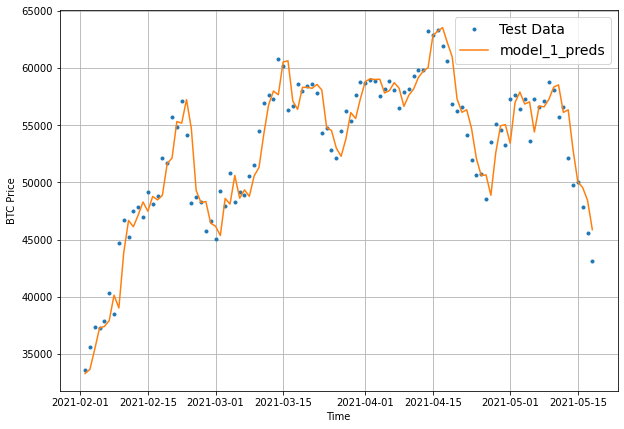

In [51]:
# Plotting our model_1 results with our test labels 
offset = 450
plt.figure(figsize= (10 , 7))

# Account for test_window offset and index into test_labels to ensure correct plotting 
plot_time_series(timesteps= X_test[-len(test_windows):] ,
                 values = test_labels[: , 0] ,
                 start= offset ,
                 format = '.' ,
                 label = 'Test Data')

plot_time_series(timesteps= X_test[-len(test_windows):] ,
                 values = model_1_preds , 
                  start = offset , 
                 format = '-', 
                 label = 'model_1_preds')
                 

Why there is a lag between test labels and predicted labels? 

Read this --> [Autocorrelation in time series](https://otexts.com/fpp2/autocorrelation.html)

In [52]:
len(X_test)  , len(test_labels) , len(model_1_preds)

(558, 556, 556)

In [53]:
test_labels[: , 0][:10]

array([8798.04205463, 9081.18687849, 8711.53433917, 8760.89271814,
       8749.52059102, 8656.97092235, 8500.64355816, 8469.2608989 ,
       8537.33965197, 8205.80636599])

### **Model 2: Dense (window = 30 , horizon = 1)**

We'll keep the previous model architecture but use a window size of 30. 

In other words we'll use the previous 30 days of Bitcoin prices and try to predict the next day price. 

Maybe more bitcoin price data will 

In [54]:
HORIZON = 1 # labels 
WINDOW_SIZE = 30 

In [55]:
# Make windowed datta with appropriate horizon and window sizes 
full_windows , full_labels = make_windows(prices , window_size= 30 , horizon= 1)
len(full_windows) , len(full_labels)

(2757, 2757)

In [56]:
# Now make the train and test splits of the windows and labels 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , 
                                                                                   full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2205, 552, 2205, 552)

In [57]:
full_windows.shape

(2757, 30)

In [58]:
# Building the same model with a different window size 
inputs = layers.Input(WINDOW_SIZE , name = 'input_layer')
x = layers.Dense(128 , activation= 'relu')(inputs)
outputs = layers.Dense(HORIZON , activation='linear')(x)

# Packing into a model 
model_2 = tf.keras.Model(inputs , outputs , name = 'model_2_dense')

# Compile the model 
model_2.compile(loss = 'mae' , 
                optimizer = 'adam' , 
                metrics = ['mae'])

# Fit the model 
model_2.fit(x = train_windows , 
            y = train_labels , 
            epochs = 100 , 
            verbose = 0 , 
            batch_size = 128, 
            validation_data = (test_windows , test_labels) , 
            callbacks = [create_model_checkpoint(model_name= model_2.name)])

INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiment

In [59]:
# Evaluate the test data on the last epoch results 
model_2.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 613.4174 - mae: 613.4174


[613.4174194335938, 613.4174194335938]

In [60]:
# Loading in the best checkpoint 
model_2 = tf.keras.models.load_model('model_experiment/model_2_dense')
model_2.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 603.6956 - mae: 603.6956


[603.695556640625, 603.695556640625]

In [61]:
# Get the forecast predictions 
model_2_preds = make_preds(model_2 , 
                           test_windows)

In [62]:
# Evaluate the results for our model 2 prediction 
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels) , 
                                 y_pred = model_2_preds)
model_2_results

{'mae': 603.69556,
 'mape': 2.6850212,
 'mase': 1.0552658,
 'mse': 1284773.0,
 'rmse': 1133.4783}

In [63]:
# Checking our baseline results 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

it looks like `model_2` performs worse than the native model as well as `model_1`. 

How does the plot predictions look like? 

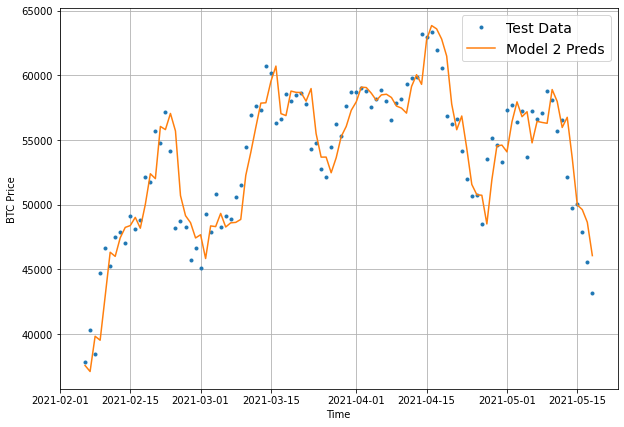

In [64]:
plt.figure(figsize=(10 , 7))
offset = 450

# Account for the test_window offset 
plot_time_series(timesteps= X_test[-len(test_windows):] , 
                 values = test_labels[: , 0] , 
                 label = 'Test Data' , 
                 start = offset)

plot_time_series(timesteps= X_test[-len(test_windows):] , 
                 values = model_2_preds , 
                 start = offset , 
                 format = '-' , 
                 label = 'Model 2 Preds')

### **Model 3: Dense(window = 30 , horizon = 7)** 

We're going to use the same model architecture but with different windows and horizon size 


In [65]:
HORIZON = 7 # predict the prices for next 7 days 
WINDOW_SIZE = 30 # previous 30 days 

# Making the window size data 
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon = HORIZON)
len(full_windows) , len(full_labels)

(2751, 2751)

In [66]:
full_windows.shape

(2751, 30)

In [67]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [68]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2200, 551, 2200, 551)

In [69]:
train_windows.shape

(2200, 30)

In [70]:
# Creating the train and test split 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , 
                                                                                   full_labels)
len(train_windows) , len(test_windows) , len(train_labels) , len(test_labels)

(2200, 551, 2200, 551)

In [71]:
full_windows.shape

(2751, 30)

In [72]:
# # Building the same model architecture  with different window and horizon size 
# inputs = layers.Input(shape = (WINDOW_SIZE , ) , name = 'input_layer')
# print(inputs.shape)
# x = layers.Dense(128 , activation= 'relu')(inputs)
# outputs = layers.Dense(HORIZON)(x)

# # Packing into a model 
# model_3 = tf.keras.Model(inputs , outputs , name ='model_3_dense')

# # Compiling the model 
# model_3.compile(loss = 'mae', 
#                 optimizer = 'adam' , 
#                 metrics = ['mae'])

# # Fit the model 
# model_3.fit(x = train_windows , 
#             y = train_labels , 
#             epochs = 100 , 
#             verbose = 0 , 
#             validation_data = (test_windows , test_labels) , 
#             batch_size = 128 , 
#             callbacks = [create_model_checkpoint(model_name = model_3.name)])

# Cant use functional api for shape reasons not sure why. 

In [73]:
train_windows.shape , train_labels.shape

((2200, 30), (2200, 7))

In [74]:
# From the course 
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam() , 
                metrics = ['mae'])

model_3.fit(x =train_windows,
            y = train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiment

In [75]:
# Evaluating the last epochs results
model_3.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525 - mae: 1300.1525


[1300.1524658203125, 1300.1524658203125]

In [76]:
# Now loading in the checkpoint which has the best model 
model_3 = tf.keras.models.load_model('/content/model_experiment/model_3_dense')
model_3.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063 - mae: 1237.5063


[1237.50634765625, 1237.50634765625]

In [77]:
# The predictions are going to be 7 steps at a time (size of the horizon)
model_3_preds = make_preds(model_3 , 
                           test_windows)
model_3_preds[:10]

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ],
       [8797.741 , 8840.092 , 9027.696 , 8974.782 , 9149.172 , 9229.461 ,
        8984.064 ],
       [8652.236 , 8803.886 , 9133.416 , 8876.115 , 8879.495 , 9111.173 ,
        8917.195 ],
       [8435.782 , 8533.1   , 8950.898 , 8667.981 , 8776.91  , 8752.906 ,
        8673.282 ],
       [8423.753 , 8317.124 , 8790.316 , 8533.364 , 8648.607 , 8623.754 ,
        8503.704 ],
       [8550.177 , 8408.631 , 8685.886 , 8591.83  , 8562.819 , 8604.392 ,
        8522.676 ]], dtype=floa

In [78]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53293 ,
         537.854   ,  545.6617  ,  485.9228  ,  584.49713 ,  687.38214 ,
         836.2264  ,  755.1576  ,  731.4957  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80217 ,  188.10805 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.8148  ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78871 ,  190.81174 ,  179.15994 ,  228.26004 ,
         314.44022 ,  379.09235 ,  278.32526 ,  295.34702 ,  299.3852  ,
         248.64983 ,  299.75668 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.9412  ,
          54.825542,   73.79555 ,  103.60121 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57199 ,  146.91273 ,  240.42912 ,
         351.00656 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.9811  ,  277.2947  ,  301.8247  ,  455.718   ,
         458.9603  ,  503.4438  ,  522.3119 

In [79]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1237.5063>

Alright its not what we expected we got our `model_3_results` as multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time). Before we had 1 so it was easy for our evaluation function. 

Now lets adjust the `evaluate_preds()` function to work with multiple shapes of data. 


#### Make our evaluation function work for larger horizons 


In [80]:
def evaluate_preds(y_true , y_pred):

  # Make sure float32 (metric calculations)
  y_true = tf.cast(y_true , dtype= tf.float32)
  y_pred = tf.cast(y_pred , dtype = tf.float32)

  # Claculate various metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce it to single number)
  if mae.ndim > 0: 
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

 

In [81]:
# Using the above updated function 
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels) , 
                                 y_pred = model_3_preds)
model_3_results # Models performance is worse 

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7478}

In [82]:
# Gettin the baseline results 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

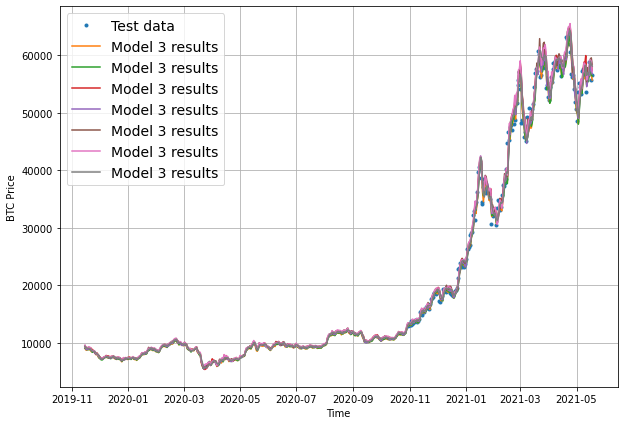

In [83]:
# Visualizing the above model results 
offset = 350 
plt.figure(figsize = (10 ,7))
plot_time_series(timesteps = X_test[-len(test_windows):] , 
                 values = test_labels[: , 0], 
                 start = offset , 
                 label= 'Test data')
plot_time_series(timesteps = X_test[-len(test_windows):] , 
                 values = model_3_preds , 
                  format = '-' , 
                 label = 'Model 3 results')

Well thats a funky looking plot, well this happens because our `model_3_preds` is a multi-dimensional array. 

We can solve that by aggregating our models predictions. 

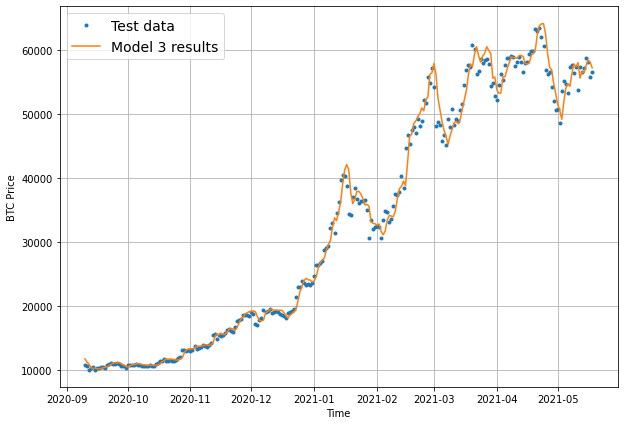

In [84]:
# Visualizing the above model results 
offset = 300 
plt.figure(figsize = (10 ,7))
plot_time_series(timesteps = X_test[-len(test_windows):] , 
                 values = test_labels[: , 0], 
                 start = offset , 
                 label= 'Test data')
plot_time_series(timesteps = X_test[-len(test_windows):] , 
                 values = tf.reduce_mean(model_3_preds , axis = 1) , 
                 start = offset ,
                  format = '-' , 
                 label = 'Model 3 results')

> **🔑  Note** Aggregating the predictions (e.g. reducing a 7-day horizon to one value such as the mean) loses information from the original prediction. As in, the model predictions were trained to be made for 7-days but by reducing them to one, we gain the ability to plot them visually but we lose the extra information contained across multiple days. 

#### Which of our models is performing so far? 

So we;ve trained 3 models which use the same architecture but use different data inputs. 

Lets compare them with naive mdoels to see which model is performing best so far.

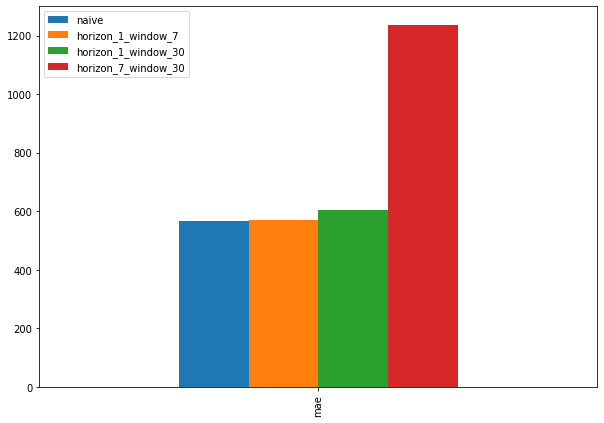

In [85]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

Great looking at the plot it shows our naive model is the best performing one till now (its very hard to beat a naive model in the open systems) but the dense model with a horizon of 1 and window size of 7 looks to be performing the closest. 

Because of this lets use the same window size and the horizon for our next series of experiments. 

**What the hell is autocorrelation**?
> Why are the naive results so good? One of the reason could be due to presence of **autocorrelation** in the data. If a time series has **autocorrelation** it means the value at `t + 1` (the next timestep) is typically close to the value of `t` (the current timestep). In other words, todays value is probably pretty close to yesterdays value. Of coruse, this isn't always the case but when it is, a naive model will often get fairly good results. 

> Resource : https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424


So thats why our naive model was able to perform well, and it show that our our current and the next timesteps are pretty closer at most of the instances. 

### **Model 4: Conv 1D**  

We have been using dense layers to build our time series model for so long, now lets move onto using the `Conv 1D` layer. 

As we know Conv1D model can be used for (seq2seq) sequence to sequence problem. And in our case the, 
- input sequence is the previous 7 days of Bitcoin price data (or) `window_size`
- output is the next day (or) `horizon`


In a seq2seq problem we call it as many to one problem. Lets crecreatte the datasets for our Conv1D


In [86]:
HORIZON = 1 # predict the next day 
WINDOW_SIZE = 7 # use previous one week worth of data (as inputs)

In [87]:
# Create windowed dataset 
full_windows , full_labels = make_windows(prices , window_size= WINDOW_SIZE , horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [88]:
# Create the train and test splits 
train_windows , test_windows , train_labels , test_labels = make_train_test_splits(full_windows , full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)


(2224, 556, 2224, 556)

In [89]:
train_windows.shape , full_windows.shape , full_labels.shape

((2224, 7), (2780, 7), (2780, 1))

Since we're going to be using `Conv1D` model we need to make sure our **input shapes are correct**. 

We need an input shape of: `(batch_size , timesteps , input_dim)`

However our data isnt in the shape yet. 






In [90]:
# Check our data shape 
train_windows[0].shape # returns (Windo_size, )

(7,)

In [91]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works 
x = tf.constant(train_windows[0])

In [92]:
# Using the lambda layer to add extra dimension (using expand dims)
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(x)
expand_dims_layer

<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[123.65499],
       [125.455  ],
       [108.58483],
       [118.67466],
       [121.33866],
       [120.65533],
       [121.795  ]], dtype=float32)>

In [93]:
print(f'Original shape: {x.shape}') # window_size
print(f'Expanded shape: {expand_dims_layer.shape}\n\n') # (window_size , input_dim)
print(f'Original values with expanded shape:\n {expand_dims_layer}')

Original shape: (7,)
Expanded shape: (7, 1)


Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [94]:
# Now building the Conv1D model 

inputs = layers.Input(shape = (WINDOW_SIZE ,) , name ='input_layer')
expand_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis = 1) , name = 'expand_dim_layer')(inputs)
x = layers.Conv1D(filters = 128 , 
                  kernel_size = 5 , 
                  padding ='causal' , activation = 'relu')(expand_layer)
outputs = layers.Dense(HORIZON)(x)

# Packing into a model 
model_4 = tf.keras.Model(inputs , outputs , name = 'conv1d_model')

# Compiling the model 
model_4.compile(loss = 'mae', 
                optimizer = tf.keras.optimizers.Adam())

# Fit the model 
model_4.fit(x = train_windows , 
            y = train_labels , 
            epochs = 100 , 
            batch_size = 128 , 
            verbose = 0 , 
            validation_data = (test_windows , test_labels) , 
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment/conv1d_model

In [95]:
# Evaluating the model results 
model_4 = tf.keras.models.load_model('model_experiment/conv1d_model')
model_4.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.6167


569.61669921875

In [96]:
# Make predictions 
model_4_preds = make_preds(model_4 , test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8910.764, 8808.881, 9009.132, 8804.391, 8759.231, 8738.199,
       8705.465, 8556.178, 8469.612, 8534.404], dtype=float32)>

In [97]:
# Evaluate the predictions 
model_4_results = evaluate_preds(tf.squeeze(test_labels) , 
                                 model_4_preds)
model_4_results

{'mae': 569.61676,
 'mape': 2.5637596,
 'mase': 1.0006589,
 'mse': 1185832.8,
 'rmse': 1088.9595}

In [98]:
# Baseline results 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Model 5: RNN (LSTM) 

We can also use recurrent neural networks to model our sequential time series data. 

Lets use the same model we did for the Conv1D but except this time we will create an LSTM-cell powered RNN to model our Bitcoin data. 

Like the Conv1D model even the LSTM layers take a tensor with shape `(batch_size , timesteps ,feature)` dimensions and we will use the lambda layer to adjust the shape of our input tensors. 

In [99]:
tf.random.set_seed(42)

# Building a LSTM model 
inputs  = layers.Input(shape = (WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x , axis = 1))(inputs)
x = layers.LSTM(128 , activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)

# Packing into a model 
model_5 = tf.keras.Model(inputs , outputs , name = 'model_5_lstm')

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_lstm

In [100]:
# Evaluate the lstm model 
model_5 = tf.keras.models.load_model('/content/model_experiment/model_5_lstm')
model_5.evaluate(test_windows , test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 598.6813


598.6813354492188

In [101]:
# Make predictions with our LSTM model 
model_5_preds = make_preds(model_5 , test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8990.325, 8818.501, 8999.41 , 8839.997, 8732.248, 8782.134,
       8740.724, 8544.819, 8509.087, 8535.617], dtype=float32)>

In [102]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 598.6813,
 'mape': 2.6928957,
 'mase': 1.0517172,
 'mse': 1280250.8,
 'rmse': 1131.4817}

In [103]:
# Naive model results 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

It seems even with an LSTM-powered RNN weren't able to beat our naive model results. 

What about adding another variable to our data? 

Yup, lets add another variable and make our data into multivariate time series data. 

> 🔑 Note: Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time series 

So far only the naive forecast model has been performing well and till now we have been training on a single variable (also called univariate time series) to be more precise we used only the historical price of a Bitcoin. 

If prediciting the price of Bitcoin hasnt worked out very well, maybe giving our model more information may help and we could actually feed almost anything to our models and they would still try to find patterns. 

What would be better as if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related). 

And of course this will be different for almost every time series problem we work on, lets see if we can add [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) and does it adds any predictive power to our models. 

**What is Bitcoin block reward size?**

The bitcoin block reward size is the number of Bitcoin someone recieves from mining a Bitcoin block. At its inception, the Bitcoin block reward size was 50. 

But for every four years or so, the Bitcoin block reward halves. 

Lets add the Bitcoin halving events into our univariate data. 

As we can see as the year progress the block reward is getting reduced. What does it implies? 
- It seems at January 2009, if you are mining a block you get 50 bitcoins in return. 
- But in 2020 the halving period took place and the block reward **drops from 50 to 6.25**. So now mining a block will get you only 6.25 bitcoins. 



> For example, the block reward size went from 50(start Jan 2009) to 25 on Novemeber 2012.

> **🔑 Note:** Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from univariate (only the historical price of Bitcoin) to multivariate (the price of Bitcoin as well as the block reward size).

In [104]:
# Looking into our df 
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [105]:
# Lets add the bitcoin halving events to our dataset above (not sure adding more data might work)
block_reward_1 = 50 # 3rd january 2009 - this block reward isnt in our data (where our data starts from Oct 1 2013)
block_reward_2 = 25 # 8th Nov 2012 
block_reward_3 = 12.5 # 9 July 2016  
block_reward_4 = 6.25 # 18 May 2020


# Block reward dates 
block_reward_2_datetime = np.datetime64('2012-11-28')
block_reward_3_datetime = np.datetime64('2016-07-09')
block_reward_4_datetime = np.datetime64('2020-05-11')

Now we have to add the `block_reward` between the range of the datetime. 

For instance, for datetime between `2012-11-28` (`2013-10-01`) to `2016-07-08` we should add a **block_reward** of 25. 

In [106]:
# block_2 = pd.date_range(start = '2013-10-01' , end = '2016-07-08')
# block_3 = pd.date_range(start = '2016-07-09' , end = '2020-05-17')
# block_4 = pd.date_range(start = '2020-05-18' , end = '2021-05-18')

# len(block_2) + len(block_3) + len(block_4) == bitcoin_prices.shape[0]

# # Another method (by indexing the date)
# bitcoin_prices.loc[block_2[0]:block_2[-1]].index

# bitcoin_prices.drop('block_reward' , inplace = True , axis = 1)


# bitcoin_prices['block_reward'] = None
# bitcoin_prices.head()

In [107]:
# Create date ranges of where specific block_reward values should be 
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days

block_reward_2_days , block_reward_3_days

(1012, 2414)

This is important because if we're going to use multiple variables for our time series, they have to the same frequency as our original variable. For example, if our Bitcoin prices are daily, we need the block reward values to be daily as well.



In [108]:
# Addd in a block_reward column 
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in block_reward values as a feature to our dataframe (setting the values of block rewards)
bitcoin_prices_block.iloc[:block_reward_2_days , -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days , -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days: , -1] = block_reward_3 = block_reward_4

In [109]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [110]:
# Check if there is the right amount of block_reward values (25 , 12.5 , 6.25)
bitcoin_prices_block['block_reward'].value_counts()

12.50    1402
25.00    1012
6.25      373
Name: block_reward, dtype: int64

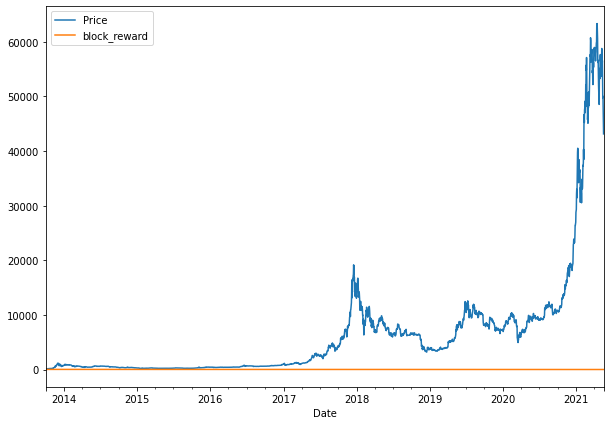

In [111]:
bitcoin_prices_block.plot(figsize = (10 , 7))

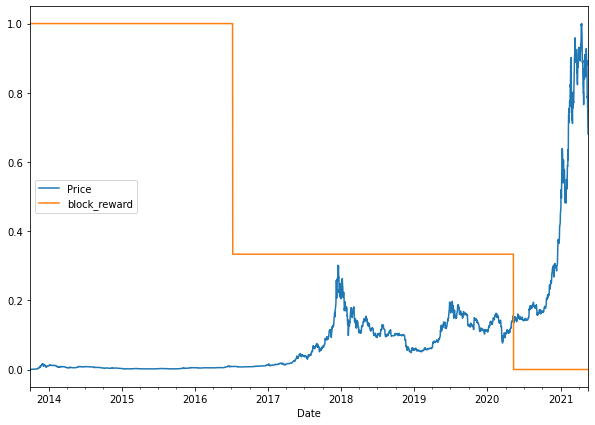

In [112]:
# Plot the block reward vs price over time 
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price' , 'block_reward']]), 
                                     columns = bitcoin_prices_block.columns , 
                                     index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize = (10 , 7))

### **Making a windowed dataset with pandas**

We can't use the previous function to window our **multivariate** time series, hence it works only for the **univariate** time series. 

Since our data is in a pandas DataFrame, we can leveragee the `pandas.DataFrame.shift()` method to create a windowed multivariate time series. 

> The `shift()` method offsets an index by a specified number of periods. 

In [113]:
# At first setting up the dataset hyperparameters (since the earlier one worked best)
HORIZON = 1 
WINDOW_SIZE = 7 

In [114]:
# Make a copy of the Bitcoin historical data with block reward feature 
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns 
for i in range(WINDOW_SIZE): # shift values for each step in window_size
  bitcoin_prices_windowed[f'Price+{i+1}'] = bitcoin_prices_windowed['Price'].shift(periods = i +1)


# Looking into the windowed dataset
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [115]:
bitcoin_prices_windowed.head(20)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe. 

```
[0 , 1, 2 ,3 ,4 ,5 , 6, block_reward] --> [7]
[1, 2 ,3 ,4 ,5 , 6, 7,  block_reward] --> [8]
[2 ,3 ,4 ,5 , 6, ,7, 8, block_reward] --> [9]

{[horizon: 123.03300] |	 [window: 121.79500	120.65533	121.33866	118.67466	108.58483	125.45500	123.65499] |   [block: 25] }
```

Now lets remove the `NaN` values from our dataframe 

In [116]:
# Create X (windows) and y (horizons) features 
X = bitcoin_prices_windowed.dropna().drop('Price' , axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [117]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

We are one step away from building the models. Now we have to make train and test split for our multivariate time series data. 


In [118]:
# Make train and test sets 
split_size = int(len(X) * 0.8)

# Indexing and making the splits 
X_train , y_train = X[:split_size] , y[:split_size]
X_test , y_test = X[split_size:] , y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [119]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((2224, 8), (2224,), (556, 8), (556,))

In [120]:
X_train[:2]

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002


## **Continuing our Modelling Experiments**

Lets see what are the modelling experiments still left for us, 
- **Model 6** Same as 1 (but with multivariate data) (horizon =1 , window = 7) Block reward size
- **Model 7** N-BEATs Algorithm (horizon =1 , window =7)
- **Model 8** Ensemble (multiple models optimized on different loss functions) (horizon = 1 , window =7)
- **Model 9** Future prediction model (model to predict future values) (horizon = 1 , window= 7)
- **Model 10** Same as 1 (but with turkey 🦃 data introduced) (horizon = 1 , window= 7)


### Model 6: Dense model with multivariate date 

Lets train the same model as the `model_1` architecture but with a mutlivariate data. 

In [121]:
# Building the model 6 
tf.random.set_seed(42) 

# Using functional api 
from tensorflow.keras import layers
inputs = layers.Input(shape = (WINDOW_SIZE+1 ,) , name = 'input_layer') # window_size + block_rewards = 8
x = layers.Dense(128 , activation= 'relu')(inputs)
x = layers.Dense(128 , activation= 'relu')(x)
outputs = layers.Dense(HORIZON)(x)

# Packing into a model 
model_6 = tf.keras.Model(inputs , outputs , name = 'model_5_dense_multivariate')

# Compiling the model 
model_6.compile(loss = 'mae', 
                optimizer = 'adam', 
                metrics = ['mae'])

# Fitting the model 
model_6.fit(X_train , y_train , 
            epochs = 100 , 
            verbose =0 , 
            validation_data = (X_test , y_test), 
            batch_size = 128 , 
            callbacks = [create_model_checkpoint(model_6.name)])


INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/model_5_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiment/mo

In [122]:
# Evaluating our best performing model
model_6 = tf.keras.models.load_model('/content/model_experiment/model_5_dense_multivariate')
model_6.evaluate(X_test , y_test)

18/18 [==============================] - 0s 2ms/step - loss: 568.8121 - mae: 568.8121


[568.8120727539062, 568.8120727539062]

In [123]:
# Making predictions with our model 
model_6_preds = make_preds(model_6 , X_test)
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8815.291, 8771.752, 9053.797, 8730.463, 8721.519, 8752.402,
       8654.198, 8493.692, 8457.621, 8522.897], dtype=float32)>

In [124]:
# Evaluating our predictions 
model_6_results = evaluate_preds(y_true= y_test , 
                                 y_pred = model_6_preds)
model_6_results 

{'mae': 568.812,
 'mape': 2.5536277,
 'mase': 0.99924517,
 'mse': 1164400.6,
 'rmse': 1079.074}

In [125]:
# Looking at our baseline results 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Adding an extra dense layer to the above model slightly improved the performance of our model. 

> **📖 Resource:** For different ideas on how to improve a neural network model (from a model perspective), refer to the Improving a model section in notebook 02.

> **🛠 Exercise(s):**
1. Is there a better way to create this model? As in, should the block_reward feature be bundled in with the Bitcoin historical price feature? Perhaps you could test whether building a multi-input model (e.g. one model input for Bitcoin price history and one model input for block_reward) works better? See Model 4: Hybrid embedding section of notebook 09 for an idea on how to create a multi-input model.

So far we have been using the models that we were already used to. But like we did in the SkimLit section where we implemented the model from the paper, we can also do the same in here. 

The model associated with this paper known as N-Beats alogrithm. 

Paper --> https://arxiv.org/pdf/1905.10437.pdf

## **Model 7: N-Beats algorithm** (Big dog) 

*N-Beats -> Neural basis expansion analysis for interpretable time series forecasting.*

**What is it all about?**
- Solving univariate time series forecasting problems. 
- The architecture design they used in the competition is called N-Beats. 
- The base architecture should be simple and generic, yet deep. 
- Secondly the architecture shouldnt rely on time-series specific feature engineering or input scaling. 


Going to replicate the N-Beats algorithm with TensorFlow with window (input) and horizon (output).

Things we're going to focus on: 
- Replicating the model architecture in [Figure 1](https://arxiv.org/pdf/1905.10437.pdf) of the paper. 
- Using the same hyperparameters as the paper which can be found in [APPENDIX D](https://arxiv.org/pdf/1905.10437.pdf).
- The **Block Input** is consists of fully connected layers. 
- And each of the above **Blocks** is connected in residual connections. [+ forecast] [- backcast] in the figure below. 
- And its stacked into a whole block called **Stack Input** where we stack the **Block Inputs** with a residual connection. 
- Right after it, the Stack Input block is stacked together and it returns both the backcast and the forecast. 

But we are in here to predict the forecast (horizon) so will we will slice it off from it. 

**Why we're replicating it**? 
- This will allow us to practice replicating a paper with TensorFlow code. 
- We will see how to use TensorFlow layer subclassing to make our own custom layers. 
Get experience using the Functional API to create a custom architecture. 
- Potentially get state of the art result in our paper. 


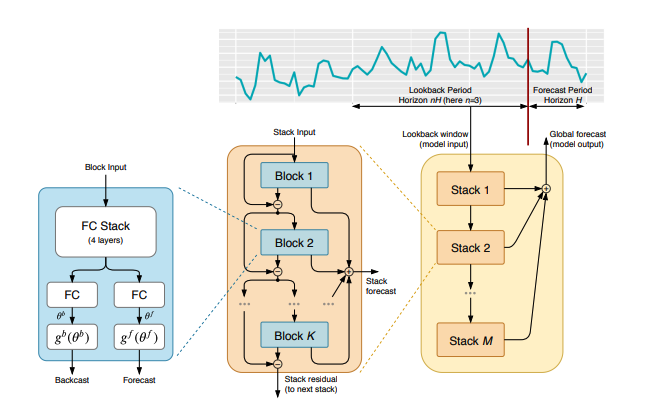

### Building and testing the N-Beats Block layer 

In paper, its on the section 3.1 Basic Block. 
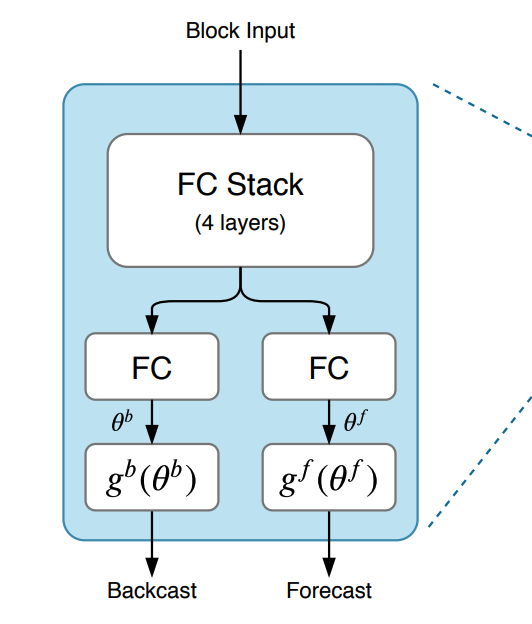


Because the N-Beats block layer doesnt exist in TensorFlow, we've go to create it. 

To create custom layers and models in TensorFlow we can use subclassing. 
https://www.tensorflow.org/guide/keras/custom_layers_and_models



In [126]:
# Create N-Beat Block custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self , 
               input_size: int , # Window_size 
               theta_size: int , # Window_size + Horizon (because we are unpacking both)
               horizon: int , 
               n_neurons: int , 
               n_layers: int , 
               **kwargs): # the kwargs argument takes carre of all the arguments for the parent class which is Layer like (trainable , input_shape , etc..)
    super().__init__(**kwargs)
    self.input_size = input_size # the window size  
    self.theta_size = theta_size 
    self.horizon = horizon # the horizon (output forecast)
    self.n_neurons = n_neurons  # number of neurons in a layer 
    self.n_layers = n_layers # how many layers? 

    # Block contains stack of 4 fully connect layers each has ReLU activations (we're creating the FC Stack)
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation = 'relu') for _ in range(n_layers)]

    # Output of block is a theta layer with theta activation
    self.theta_layer = tf.keras.layers.Dense(theta_size , activation= 'linear' , name = 'thetha_layer')

  def call(self , inputs):
      x = inputs 
      for layer in self.hidden:
        x = layer(x) # x gets updated 
      theta = self.theta_layer(x)

      # Output the backcast and forecat from theta 
      backcast , forecast = theta[: , :self.input_size] , theta[: , -self.horizon:]
      return backcast , forecast



Lets test our NBeatsBlock class.

To do so we'll make some dummy inputs and outputs. 


In [127]:
# Set up dummy NBeatsBlock layer
dummy_nbeats_block_layer = NBeatsBlock(input_size= WINDOW_SIZE , 
                                       theta_size = WINDOW_SIZE + HORIZON , # because thetha has to output both forecast and backcast
                                       horizon = HORIZON, 
                                       n_neurons = 128  , 
                                       n_layers = 4)
dummy_nbeats_block_layer

In [128]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1 , axis = 0) # input shape to the model has to reflect dense layer input requirements (ndim = 2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [129]:
# Pass dummy inputs into our dummy block layer 
dummy_backcast , dummy_forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activations output of the theta layer (they're random due to no training)
print(f'Backcast: {tf.squeeze(dummy_backcast.numpy())}')
print(f'Forecast: {tf.squeeze(dummy_forecast.numpy())}')

Backcast: [-0.46348703  0.10944437 -0.43355325  0.936024   -0.35703513 -0.17927606
 -0.34048352]
Forecast: -0.4397900402545929


Setting up the `NBeatsBlock` custom layer we see: 
- The class inherits from `tf.keras.layers.Layer` (this gives it alll f the methods associated with `tf.keras.layers.Layer`. 
- The constructor (`def __init__(...)`) takes all of the layer's hyperparameters as well as the `**kwargs` argument. 
  - The `**kwargs` argument takes care of all the hyperparameters which arent mentioned in the constructor such as, `input_shape`, `trainable` and `name`. 
- In the constructor, the block architecture layers are creatted.: 
  - The hidden layers are created as a stack of fully connected with `n_neurons` hidden units layers with ReLU activation. 
  - The thetaa layer uses `theta_size` hidden units as well as linear activation. 
- The `call()` method is what run when the layer is called: 
  - It first passes the inputs (the historical Bitcoin data) through each of the hidden layers (a stack of fully connected layers with ReLU activation). 
  - After the inputs have been through each of the fully connected layers, they get passed through the theta layer where the backcast (backwards predictions, shape: `input_size` ) and. forecast (forward predictions, shape: `horizon`) are returned. 


```
-------------------------       ---------
Blocks combined together|   --> |Stacks |
-------------------------       ---------

-------------------------       ------------
Stacks together combined| --->  | The Model|
-------------------------       ------------

```
  



### Prepariing data for the N-Beats algorithm using `tf.data`

To make our input data to load as fast as possible we're going to be adhering the performant data pipeline steps. 

In [130]:
HORIZON = 1 
WINDOW_SIZE = 7 

In [131]:
# Create N-Beats data inputs (NBeats works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [132]:
# Add windowed columns 
bitcoin_prices_nbeats = bitcoin_prices.copy() 

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods = i + 1)
bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [133]:
# Make features and labels (get rid of NaN values)
X = bitcoin_prices_nbeats.dropna().drop('Price' , axis = 1) 
y = bitcoin_prices_nbeats.dropna()['Price']

# Make the train and test splits 
split_size = int(len(X) * 0.8)
X_train , y_train = X[:split_size] , y[:split_size]
X_test , y_test = X[split_size:] , y[split_size:]

# Checking the length 
len(X_train) , len(y_train) , len(X_test) , len(y_test)

(2224, 2224, 556, 556)

In [134]:
# Time to make our dataset performant using tf.data api 
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine laels and features by zipping toegther --> (features , labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset , train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset , test_labels_dataset))

# Batch and prefetching 
BATCH_SIZE = 1024 
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset , test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

#### Setting up hyperparameters for N-Beats algorithm 

Now we will create variable for each of the hyperparameters we'll be using for our N-Beats replica. 

The N-Beats algo has a fair few number of parameters , many of them can be found in Table 18 of the paper. 


In [135]:
# Hyperparameter values from the N-Beats paper 
N_EPOCHS = 5000 # Iterations --> 5k 
N_NEURONS = 512 # Width --> 512 
N_LAYERS = 4  # No of layers in the fully connected stack (Block-Layers)
N_STACKS = 30 # Stacks --> 30 

INPUT_SIZE = WINDOW_SIZE * HORIZON  # 1H --> 1 times the horizon (in paper they used enemble of horizons)
THETA_SIZE = INPUT_SIZE + HORIZON # its the backcast and the forecast (how much input? and how much we want as the backcast)

INPUT_SIZE , THETA_SIZE

(7, 8)

### Getting ready for the residual connections (Double residual stacking) aka ResNet 

They're what makees N-BEATSS double residual stacking. 
- `tf.keras.layers.subtract(inputs)` - subtracts list of input tensors from each other. 
- `tf.keras.layers.add(inputs)` - add lists of input tensors to each other. 


We are using the above layers because we have this (+) and (-) in our residual blocks

**How do they help?**
- This approach helps in improving the trainability of deep architectures. 
- Also we gotta remember they're difficult to interpret. 
- The proposed one on the paer has two residual branches, 
  - one running over backcast prediction of each layer. 
  - another running over the forecast branch of each layer. 


**What is vanishing gradients problem**? 

When we construct a deep architecute with more neurons and layers by the time the values get to very last layers they are so small (they fall apart or vanish) and the neural network doesnt work well. 

So how to avoid this problem? 

Well thats why we use residual connections and what they do? 
- It skips the layer in our deep architecture so our gradients wont get small. 


And in N-BEATS we have two skip connections pattern whereas in the ResNet they have one. 

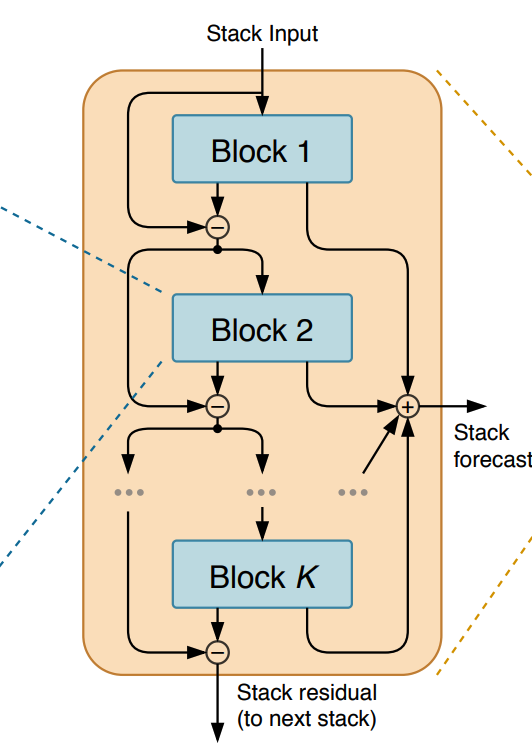

In [136]:
# (Dummy versions)  Make tensors 
tensor_1 = tf.range(10) + 10 
tensor_2 = tf.range(10)

# Subtract (using the layer)
subtracted = layers.subtract([tensor_1 , tensor_2])

# Add 
added = layers.add([tensor_1 , tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")


Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


The above two layers are what powers the N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition ](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular ResNet architecture) than previous attempts.

The deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different version of residual connections have been present in deeplearning ever since. 

**What is residual connection after all**? 

A *residual connection* (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer. 

### **Building , compiling and fitting the N-BEATS algorithm**

1. Setup an instance of the N-BEATS block layer using the `NBeatsBlock` (this'll be the initial block used for the network, and the rest will be creaed as the part of the stack).
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API). 
3. Make the initial backas and forecasts for the model with the layer created in (Step 1). 
4. Use for loop to creaye stacks of Block layers. 
5. We will use the `NBeatsBlock` class within the for loop in (Step 4) to create blocks which returns backcast and block-level forecasts. 
6. Create the double residual stacking using the subtract and add layers. 
7. Put the model inputs and outputs together using `tf.keras.Model()` . 
8. Compile the model with MAE loss (the paper used multiple losses but we'll use MAE to keep it inline with our models) and Adam optimizer with default setting as per the section **5.2 Training Methodlogy**. 
9. Fit N-BEATS model for 5000 epochs and since its fitting for so many epochs, we'll use a couple of callbacks: 
  - EarlyStopping - because the model will be training for so long, we'll stop it early if its stop improving.
  - Reduce LR on Plateau - if a model stops improving, try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards the gradients (best performance)). 

In [137]:
%%time 

tf.random.set_seed(42)

# 1. Setup and instance of NBEATS Block layer 
nbeats_block_layer = NBeatsBlock(input_size= INPUT_SIZE , 
                                 theta_size = THETA_SIZE, 
                                 horizon = HORIZON , 
                                 n_neurons = N_NEURONS , 
                                 n_layers = N_LAYERS , 
                                 name= 'Initial_Block')

# 2. Create an input layer for the N-BEATS stack 
stack_input = layers.Input(shape = (INPUT_SIZE) , name='stack_input')

# 3. Make the initial backcast and forecasts for the model with the layer created in 1. (backcast predictions + forecast predictions)
# So it will be one block and we will iterate it with for loop for creating 4 Blocks 
residuals , forecast = nbeats_block_layer(stack_input) # here we get the initial residuals 

# 4. Create Stack of Block Layers 
for i , _ in enumerate(range(N_STACKS-1)): # first stack is already created above (step 3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast 
  backcast , block_forecast = NBeatsBlock(input_size= INPUT_SIZE , 
                                          theta_size = THETA_SIZE , 
                                          horizon = HORIZON , 
                                          n_neurons = N_NEURONS , 
                                          n_layers = N_LAYERS , 
                                          name = f'NBeatsBlock_{i}')(residuals) # pass in the residuals


  # 5. Create the double residual stacking 
  residuals = layers.subtract([residuals , backcast], name = f'subtract_{i}')
  forecast = layers.add([forecast , block_forecast], name = f'add_{i}')

# 7. Put the stack model together 
model_7 = tf.keras.Model(inputs = stack_input , outputs = forecast , name = 'model_7_NBEATS') 

# 8. Compile the model 
model_7.compile(loss = 'mae', 
                optimizer = 'adam')

# Fit the model for 5000 epochs (and create couple of callbacks )
model_7.fit(train_dataset , 
            epochs = N_EPOCHS , 
            validation_data = test_dataset , 
            verbose = 0 , 
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' , 
                                                          patience = 200 , 
                                                          restore_best_weights = True) ,
                         
                         tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss' , 
                                                              patience = 100 , 
                                                              factor = 0.1,
                                                              verbose = 1)])



Epoch 00840: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 01128: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 01228: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 2min 28s, sys: 6.03 s, total: 2min 34s
Wall time: 3min 37s


In [138]:
# Evaluate the N-BEATS model on the test dataset 
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 17ms/step - loss: 572.1430


572.1430053710938

In [139]:
# Make predictions with the N-BEATS Model 
model_7_preds = make_preds(model_7 , test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8857.449, 8774.321, 9016.58 , 8774.4  , 8748.191, 8740.59 ,
       8667.066, 8502.375, 8475.426, 8509.186], dtype=float32)>

In [140]:
# Evaluate N-BEATS model preds 
model_7_results = evaluate_preds(y_true = y_test , 
                                 y_pred = model_7_preds)
model_7_results 

{'mae': 572.143,
 'mape': 2.5776775,
 'mase': 1.0050968,
 'mse': 1175007.2,
 'rmse': 1083.9775}

In [141]:
# Looking into our baseline model 
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

Shit our baseline built as a brick lol, cant even beat even by the start-of-the-art model. 

#### **Plotting our N-BEATS algorithm** 

It was unfortunate that our N-BEATS handcrafted model doesnt work as we expected. But this is the thing, just because we can use deeplearning to model our data doesnt mean it will perform well. 



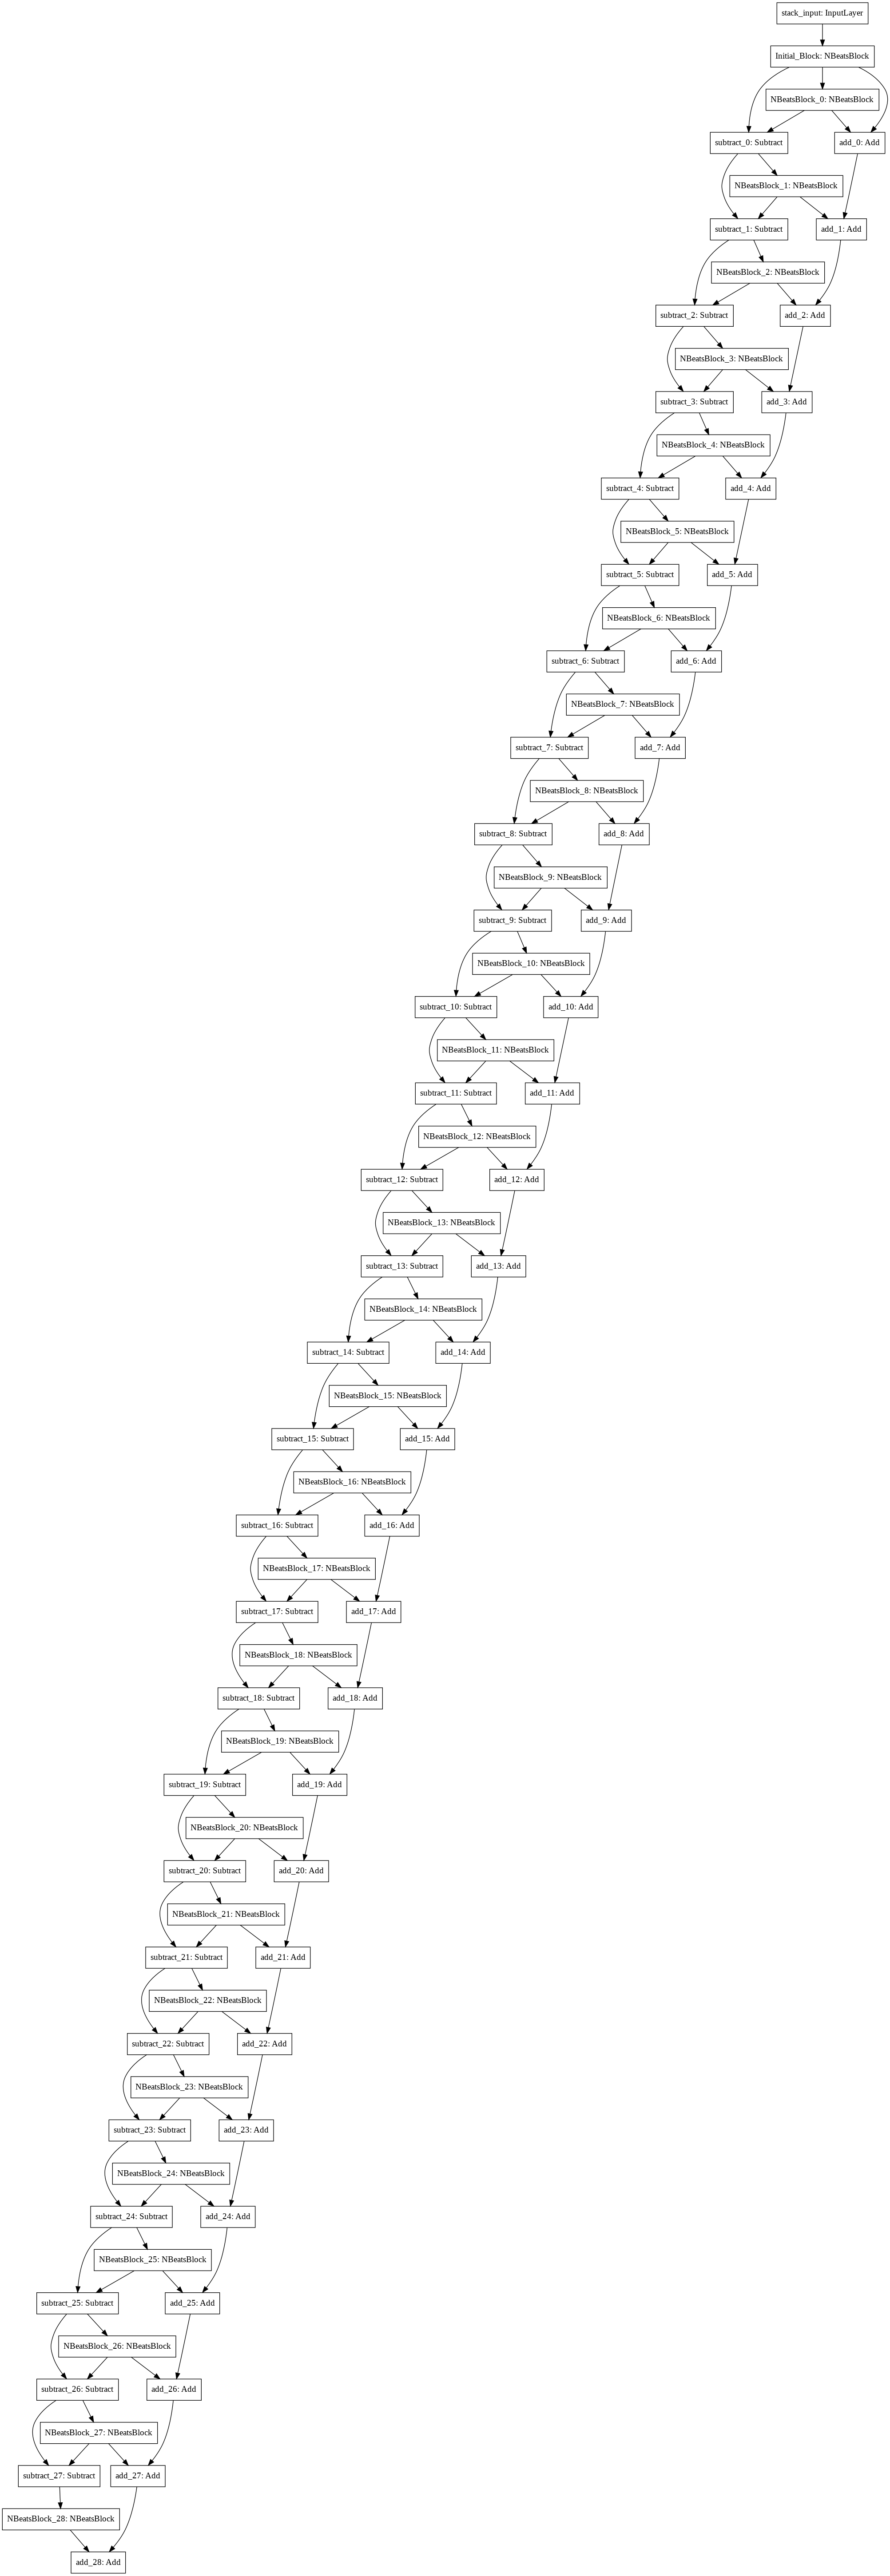

In [142]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)

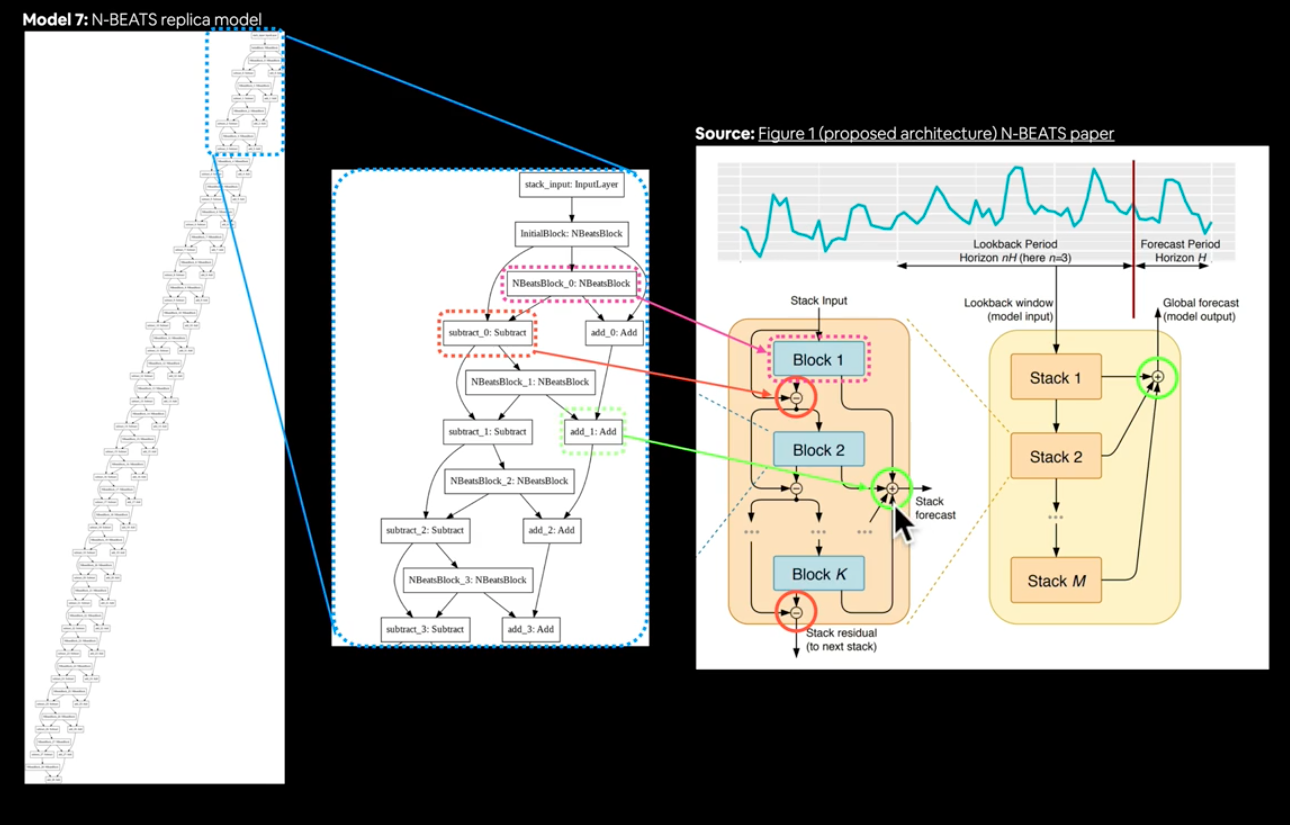

> **Note:** Our N-BEATS model replicates the N-BEATS generic architecture, the training setups are largely the same, except for the N-BEATS paper used an ensemble of models to make predictions (multiple different loss functions and multiple different lookback windows), see Table 18 of the N-BEATS paper for more. An extension could be to setup this kind of training regime and see if it improves performance.

## Model 8: Creating an ensemble model 

An ensemble levergaes the wisdom of crowd effect. 

It combines many **different** models to predict a common goal. 

Lets the see the more general definition for **ensemble**, 

An **ensemble** involves training and combining multiple different mdoels on the same problem. Ensemble models are often the types of models we'll see winning the data science competition. 

For example, in the N-BEATS paper they trained a n ensmble of models (180 in total)  to achieve the results they did using a combination of: 
- Different loss functions (sMAPE , MASE and MAPE) 
- Different window sizes (2 x horizon, 3x horizon , 4x horizon).

The benefit of ensembling models is you get the **decision of the crowd effect**. Rather than relying on a single omodels predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting). 

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results. 

But the process of adjusting the parameters (patterns) is often random guided process and its done by **SGD** and in our case we used **Adam** optimizer. 

To create our ensemble models we're going to be using a combination of,
- Different loss function (MAE  , MSE  and MAPE) 
- Randomly initialized models. 

We will start by creating a suite (heaps) of different models all attempting to model the same data. And hopefully the combined predictive power of each mdoel is better tha a single model on its own. 

**What's the plan?**

- We'll start by creating a function to produce a list of different models trained iwth different loss functions. 
- Each layer in the ensemble models will be intialized with a random normal (Gaussian) distribution using the HE-normal initialization.  


### Constructing and fitting the ensemble of models (using different loss functions)




In [143]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

Lets try the above function by running `num_iter = 5` runs for 1000 epochs. This will result in 15 total models (5 * 3) where 5 for each different loss function.

> **Note**: With ensembles, we'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time). 



In [144]:
%%time 
# Get list of trained ensemble models 
ensemble_models = get_ensemble_models(num_iter = 5 , 
                                      num_epochs = 1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 00896: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 00567: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00683: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00783: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 00891: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 00414: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 0

### Make predictions with our ensemble models 

In [145]:
# Create function which uses a list of trained models to make annd return a list of predictions 
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [146]:
# Create a list of ensemble predictions 
%%time 
ensemble_preds = make_ensemble_preds(ensemble_models , data = test_dataset)
ensemble_preds

CPU times: user 508 ms, sys: 24.9 ms, total: 533 ms
Wall time: 522 ms


In [147]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8795.064 ,  8767.4795,  9035.318 , ..., 50168.258 , 49256.816 ,
        46675.914 ],
       [ 8762.318 ,  8737.373 ,  9047.961 , ..., 49284.816 , 48544.484 ,
        45331.633 ],
       [ 8745.424 ,  8733.034 ,  9101.386 , ..., 49267.164 , 47660.426 ,
        45370.047 ],
       ...,
       [ 8951.012 ,  8798.384 ,  9069.928 , ..., 49665.414 , 49578.707 ,
        46658.52  ],
       [ 8727.072 ,  8805.693 ,  9100.191 , ..., 49579.773 , 48519.625 ,
        45070.484 ],
       [ 8814.644 ,  8759.131 ,  9038.696 , ..., 49705.168 , 48039.996 ,
        45815.457 ]], dtype=float32)>

In [148]:
y_test.shape

(556,)

In [149]:
# Evaluate ensemble model predictions 
ensemble_results = evaluate_preds(y_true= y_test , 
                                  y_pred = ensemble_preds)
ensemble_results

{'mae': 579.1204,
 'mape': 2.6531727,
 'mase': 1.0173541,
 'mse': 1182853.5,
 'rmse': 1087.3972}

In [150]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis= 0)
ensemble_mean

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8795.437 ,  8783.593 ,  9066.884 ,  8731.479 ,  8750.963 ,
        8714.937 ,  8670.91  ,  8482.462 ,  8459.301 ,  8530.145 ,
        8203.016 ,  8109.6094,  8052.2993,  7627.557 ,  7277.51  ,
        7301.4106,  7080.1025,  7216.4263,  7109.8755,  7544.8516,
        7373.655 ,  7755.8286,  7556.7905,  7401.2046,  7323.7217,
        7318.917 ,  7210.6953,  7394.9834,  7508.1265,  7540.6177,
        7543.9985,  7329.9834,  7235.1304,  7182.281 ,  7192.2954,
        7235.888 ,  7082.5776,  7106.0107,  6870.9995,  6590.4136,
        7406.067 ,  7167.3066,  7176.6772,  7253.9365,  7272.67  ,
        7199.7563,  7219.682 ,  7211.8623,  7181.257 ,  7214.753 ,
        7308.4165,  7385.157 ,  7246.155 ,  7173.2173,  7161.827 ,
        6953.802 ,  7283.5527,  7330.9067,  7368.5947,  7708.878 ,
        8064.5063,  8138.5996,  7858.1665,  8097.288 ,  8097.266 ,
        8175.9585,  8095.3257,  8752.4   ,  8887.021 ,  8775.426 ,
        8943.7

In [151]:
# In practice, median is more roboust 
ensemble_median = np.median(ensemble_preds , axis = 0)
ensemble_median

array([ 8785.564 ,  8779.829 ,  9062.955 ,  8717.055 ,  8746.146 ,
        8716.237 ,  8676.42  ,  8478.887 ,  8455.934 ,  8530.294 ,
        8200.059 ,  8105.978 ,  8048.0347,  7614.709 ,  7262.5293,
        7291.698 ,  7075.062 ,  7220.71  ,  7113.9575,  7560.1294,
        7385.318 ,  7749.312 ,  7565.115 ,  7393.839 ,  7323.166 ,
        7321.9385,  7202.822 ,  7395.5044,  7502.912 ,  7535.7505,
        7542.776 ,  7329.8647,  7231.8145,  7181.7163,  7191.5137,
        7240.2466,  7078.4995,  7103.6436,  6876.193 ,  6580.4717,
        7403.756 ,  7164.071 ,  7187.335 ,  7262.182 ,  7246.4263,
        7225.6606,  7212.556 ,  7213.2583,  7182.258 ,  7209.1265,
        7305.6274,  7384.0825,  7248.762 ,  7171.3755,  7163.9585,
        6943.597 ,  7280.5977,  7336.4023,  7362.098 ,  7725.4287,
        8062.65  ,  8140.097 ,  7861.118 ,  8096.3047,  8099.4707,
        8175.354 ,  8106.5317,  8750.619 ,  8892.373 ,  8769.914 ,
        8957.62  ,  8950.143 ,  8677.268 ,  8634.879 ,  8694.6

In [152]:
ensemble_mean.shape , ensemble_median.shape

(TensorShape([556]), (556,))

In [153]:
# Trying out the median predictions 
ensemble_results_mean = evaluate_preds(y_test , 
                                         ensemble_mean)
ensemble_results_median = evaluate_preds(y_test , 
                                         ensemble_median)

ensemble_results_mean , ensemble_results_median

({'mae': 566.6716,
  'mape': 2.580126,
  'mase': 0.995485,
  'mse': 1145913.5,
  'rmse': 1070.4735},
 {'mae': 565.60626,
  'mape': 2.578184,
  'mase': 0.99361354,
  'mse': 1139738.9,
  'rmse': 1067.5856})

Our ensemble preds come out in multiple dimensions but to combine into **point prediction** we can leverage the mean of all of the predictions or the median. 

### Plotting the prediction intervals (uncertainty estimates) of our ensemble 

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD. 

But wouldn't it be helpful if we knew a range of where that prediction came from? Its because point predictions isnt the ideal way to check our predictions. 

Instead of 50,000 USD on the dot, how about `$48K to $52K USD`? Rather getting the exact price, and we know it might not work really well and its uncertain at times. 

We will get a range of values between 48K - 52K, it means our model gives a range of possibilities that the Bitcoin price will fall somewhere in middle of this. 

This uncertain is the tradeoff of using point predictions. Because point predictions are almost always going to be wrong. So having a range of values can help with decision making.

> 📖 Resource(s):
* The steps we're about to take have been inspired by the Machine Learning Mastery blog post [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/). Check out the post for more options to measure uncertainty with neural networks.
* For an example of uncertainty estimates being used in the wild, I'd also refer to [Uber's Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber blog post](https://eng.uber.com/neural-networks-uncertainty-estimation/).


**Advnatages of using the uncertain estimates/prediction intervals over the point predictions** 

Well the first thing would be with just a value we can't infer more of the information about the estimate. So imagine, when we have a range of predictions instead of a single number. 

For instance, the prediction intervals are betweem 55 and 153, but where the point prediction is 100. 

In this case, the 100 rides might end up being 53 short. But getting the prediction intervals at times turns out to be legit 95% of the time. 

One way of getting 95% of confidence prediction intervals for a deeplearning model is the bootstrap method: 
- Take the prediction from a number of randomly intialized mdoels (and thats our ensemble model). 
- Measure the standard deviation of the predictions (ensemble predictions). 
- Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fail within 1.96 standard deviation of the mean, this is why we initialized our neural network with a normal distribution).
- To get the prediction interval upper and lower bounds, , add and subtract the value obtained in step 3) to the mean/median of the predictions

So if we use a std of 1.96 we can get the 95% of the prediction intervals. 





In [154]:
# Find upper and low bounds of ensemble predictions so we can make a plot like the Uber one 

def get_upper_lower(preds): 
  # Take the predictions of multiple randomly initialized deeplearning neural networks 

  # Measure the standard deviation of the prediction 
  std = tf.math.reduce_std(preds , axis = 0)

  # Multiply the std by 1.96 
  interval = 1.96 * std 

  # Get the prediction interval upper and lower bounds 
  preds_mean = tf.reduce_mean(preds , axis = 0)
  lower , upper = preds_mean - interval , preds_mean + interval

  return lower, upper

In [155]:
# Get the upper and lower bounds of 95% of the predictions 
lower, upper = get_upper_lower(ensemble_preds)
lower[:10] , upper[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8693.526, 8721.156, 9009.323, 8620.899, 8667.816, 8645.655,
        8607.367, 8401.189, 8394.35 , 8497.322], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8897.347, 8846.029, 9124.444, 8842.058, 8834.109, 8784.218,
        8734.453, 8563.734, 8524.252, 8562.967], dtype=float32)>)

We've got the upper and lower bounds for the 95% prediction interval, lets plot them again our model ensemble predictions. 

In [156]:
# Get the median values of ensemble preds 
ensemble_median = np.mean(ensemble_preds , axis = 0)

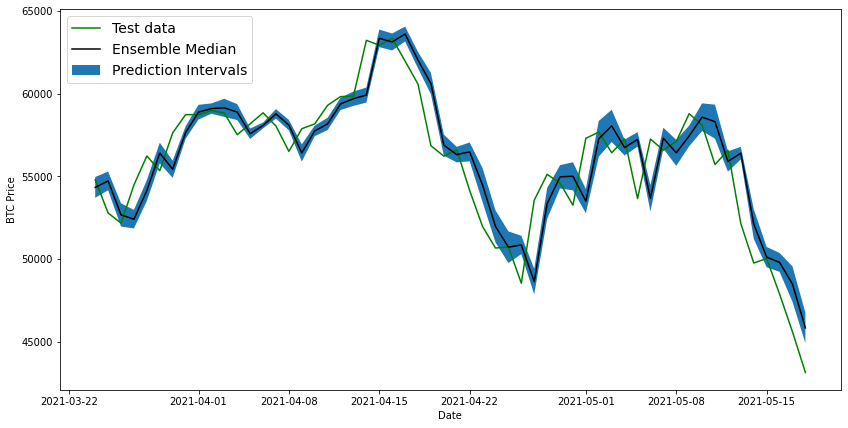

In [157]:
# Plot the median of our ensemble preds along with the prediction intervals 
offset = 500 

plt.figure(figsize=(14 , 7))
plt.plot(X_test.index[offset:], y_test[offset:] , 'g' , label = 'Test data')
plt.plot(X_test.index[offset:] , ensemble_median[offset:] , 'k-' , label = 'Ensemble Median')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.fill_between(X_test.index[offset:] , 
                 (lower)[offset:] , 
                 (upper)[offset:] , 
                 label = 'Prediction Intervals')

plt.legend(loc = 'upper left', fontsize = 14)

The intervals are estimates themselves. 

So far all of our mdoels predictions have been lagging behind the test data. 

As is they're replicating what the naive model does and just predict the previous timesteps as the next timestep. 

> **🔑  Note** These predictions intervals are estimates themselves and they have been created with the assumption that our models data is from normal distribution. 

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be overfitting the data, meaning it's basically replicating what a naïve model would do and just predicting the previous timestep value for the next value.

This would explain why previous attempts to beat the naïve forecast have been futile.

We can test this hypothesis of overfitting by creating a model to make predictions into the future and seeing what they look like.

## Aside: Two types of Uncertainity (coconut and subway) 


----Skipped for now------

## Model 9: Train a model on full historical bitcoin data to make predictions into the future. 

What would a forecasting model be worth even if we didnt use it to predict into the future? 

So far all of our models have predicted on the test dataset, however, this is only a **pseudofuture**. 

lets now build a model is capable for predicting into the future. 

To make predictions into the future, we'll train a model on the full dataset and then get to make predictions to some future horizon. 

Now we wont be splitting our data. 

> 🔑 Note: Forecasting models need to be retrained every time a forecast is made. Why? Because if Bitcoin prices are updated daily and you predict the price for tomorrow. Your model is only really valid for one day. When a new price comes out (e.g. the next day), you'll have to retrain your model to incorporate that new price to predict the next forecast.

In [158]:
HORIZON = 1 
WINDOW_SIZE = 7 

In [159]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [162]:
# Train model on entire data to make predictions for the next day 
X_all = bitcoin_prices_windowed.dropna().drop(['Price' , 'block_reward'] , axis = 1).to_numpy()

# Get the labels 
y_all = bitcoin_prices_windowed.dropna()['Price']


X_all.shape , y_all.shape

((2780, 7), (2780,))

Now lets turn them into performance optimized TensorFlow datasets. 

In [163]:
# Turn x and y into tensor datasets 
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels 
dataset_all = tf.data.Dataset.zip((features_dataset_all , labels_dataset_all))

# Batch and prefetch for optimal performance 
BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>

Now lets build a model similar to the `model_1` except with some extra layer, and we are going to fit the entire dataset for 100 epochs. 

In [167]:
tf.random.set_seed(42)

# Building the model for the whole dataset 
inputs = layers.Input(shape = (WINDOW_SIZE, ) , name = 'input_layer')
x = layers.Dense(128 , activation='relu')(inputs)
x = layers.Dense(128 , activation = 'relu')(x)
outputs = layers.Dense(HORIZON)(x)

# Packing into a model 
model_9 = tf.keras.Model(inputs , outputs , name = 'model_9_full_dataset')

# Compiling the model 
model_9.compile(loss = 'mae', 
                optimizer = 'adam')

# Fit the model 
model_9.fit(dataset_all, 
            epochs = 100 , 
            verbose = 1 ) 

Epoch 1/100
3/3 [==============================] - 0s 4ms/step - loss: 4310.6460
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2286.0432
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 455.6416
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 1394.4469
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 1358.7922
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 600.7654
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 584.5320
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 817.2908
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 534.2358
Epoch 10/100
3/3 [==============================] - 0s 5ms/step - loss: 394.9994
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 524.4480
Epoch 12/100
3/3 [==============================] - 0s 5ms/step - loss: 370.9251
Epoch 13/100
3/3 [===============

### Make predictions into the future 

We need to re-train our model everytime you want to generate a new prediction, because as the bitcoin price adds up everyday the characteristics of the model changes.

Resource --> https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387

Its because our we trained our model to predict the bitcoin the every next day. So as the price adds up we have to retrain the whole model. 

New data every single day! 

So this is how the worflow goes: (the below fig explains well) 

- Make a prediction with the model. 
- Update the input with that prediction. 
- Use the updated input to train the model. 

.
.
.
.
.
and so on......

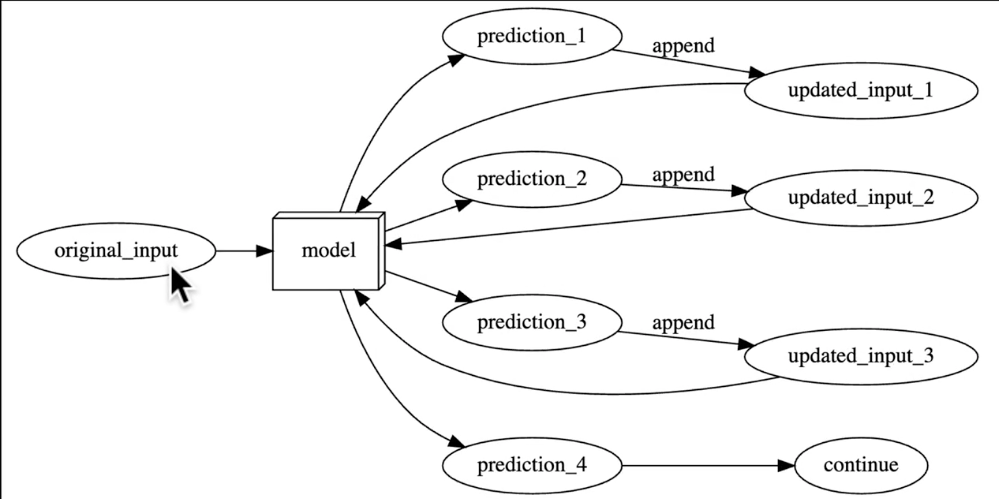

In [ ]:
# How many timesteps to predict into the future? 
INTO_FUTURE = 14            # 14 days 

To make predictions into the future we want a function which: 

1. Takes as input: 
  - a list of values (Bitcount historical price data)
  - a trained model 
  - a window into the future to predict (our `INTO_FUTURE` variable) 
  - the window size a model was trained on ('WINDOW_SIZE`), the model can only predict on the same kind of data it was trained on.. 

2. Create an empty list for future forecasts (this will be returned at the end of the end, when its full of predictions) and extracts the last `WINDOW_SIZE` values from the input values. 

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append 

In [ ]:
# Creatin a function to make prediction in the future 
def make_future_prediction(prices , model , future_windows , window_size = WINDOW_SIZE) -> list:

  # Emptry lists for the future prediction 
  future_forecasts = [] 
  last_window = prices[-window_size:]

  # Loop into the future making prediction on the window size 
  for _ in future_windows:
    # Predict on thhe last then append it again, again (our model will eventually start to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window , axis = 0))
    print(f'Predictig on:\n {last_window} --> Prediction: {tf.squeeze(future_pred).numpy()}\n')


    # Append the predictions to future forecast 
    future_forecast.append(tf.squeeze(future_pred).numpy())


    # Update th


In [169]:
WINDOW_SIZE 

7